In [99]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, pearsonr, skew, spearmanr
import datetime

In [100]:
# Read CSV into a dataframe

##################### SOLAR GENERATION DATA #####################

file_name = 'PV_BY_Day.xlsx'

df_generation = pd.read_excel(file_name, engine='openpyxl')

# print(df_generation.head())

##################### SOLAR EXPOSURE DATA #####################

file_name = 'IDCJAC0016_066207_1800_Data.csv'

df_exposure = pd.read_csv(file_name)

# print(df_exposure.head())

df_demand = pd.read_csv('totaldemand_nsw.csv', sep = ',', header = 0, parse_dates=['DATETIME'], dayfirst=True)
df_temp = pd.read_csv('temperature_nsw.csv', sep = ',', header = 0, parse_dates=['DATETIME'], dayfirst=True)

#df_demand.head()
#df_temp.head()

In [101]:
file_name1 = 'humidity_wsp_20160916_20180729.xlsx'
file_name2 = 'humidity_wsp_20180730_20200610.xlsx'
file_name3 = 'humidity_wsp_20200611_20200930.xlsx'
file_name4 = 'humidity_wsp_20201001_20220731.xlsx'

df_humidity_wsp1 = pd.read_excel(file_name1, engine='openpyxl')
df_humidity_wsp2 = pd.read_excel(file_name2, engine='openpyxl')
df_humidity_wsp3 = pd.read_excel(file_name3, engine='openpyxl')
df_humidity_wsp4 = pd.read_excel(file_name4, engine='openpyxl')

df_humidity_wsp = pd.concat([df_humidity_wsp1, df_humidity_wsp2, df_humidity_wsp3, df_humidity_wsp4], ignore_index=True)

#print(df_humidity_wsp)
#df_humidity_wsp.info()

In [102]:
column_names = ['date', 'time', 'wsp', 'humidity']
df_humidity_wsp.columns = column_names

In [103]:
# Convert 'date' column to datetime
df_humidity_wsp['date'] = pd.to_datetime(df_humidity_wsp['date'], format='%d/%m/%Y')
df_humidity_wsp['date'] = df_humidity_wsp['date'].dt.strftime('%Y-%m-%d')
                                         
# Group by 'date' and compute mean for 'wsp' and 'humidity'
agg_df_humidity_wsp = df_humidity_wsp.groupby('date').agg({'wsp': 'mean', 'humidity': 'mean'}).reset_index()

agg_df_humidity_wsp['date'] = pd.to_datetime(agg_df_humidity_wsp['date'], format='%Y-%m-%d')
# agg_df_humidity_wsp.info()

In [104]:
#Filling in all nan humidity and wsp values with average for that date

agg_df_humidity_wsp['date'] = pd.to_datetime(agg_df_humidity_wsp['date'])

# Extract month and day from the date
agg_df_humidity_wsp['month'] = agg_df_humidity_wsp['date'].dt.month
agg_df_humidity_wsp['day'] = agg_df_humidity_wsp['date'].dt.day

# Calculate average values for wsp and humidity for each month-day combination
avg_values = agg_df_humidity_wsp.groupby(['month', 'day'])[['wsp', 'humidity']].mean().reset_index()

# Merge average values back to the original dataframe
agg_df_humidity_wsp = agg_df_humidity_wsp.merge(avg_values, on=['month', 'day'], suffixes=('', '_avg'))

# Replace NaN values with the average values
agg_df_humidity_wsp['wsp'].fillna(agg_df_humidity_wsp['wsp_avg'], inplace=True)
agg_df_humidity_wsp['humidity'].fillna(agg_df_humidity_wsp['humidity_avg'], inplace=True)

# Drop the auxiliary columns
agg_df_humidity_wsp.drop(columns=['month', 'day', 'wsp_avg', 'humidity_avg'], inplace=True)


In [105]:
df_demand['date'] = df_demand['DATETIME'].dt.date
df_demand['date'] = pd.to_datetime(df_demand['date'])

df_demand = df_demand.drop(df_demand.iloc[:,0:1].columns, axis=1)

df_demand = df_demand.rename(columns={'TOTALDEMAND': 'total_demand'})

df_demand = df_demand[df_demand['date'] < '2022-08-01']
df_demand = df_demand[df_demand['date'] >= '2016-09-16']

agg_df_demand = df_demand.groupby(['date'])['total_demand'].sum().reset_index()

In [106]:
df_temp['date'] = df_temp['DATETIME'].dt.date
df_temp['date'] = pd.to_datetime(df_temp['date'])

df_temp = df_temp.drop(df_temp.iloc[:,0:1].columns, axis=1)

df_temp = df_temp.rename(columns={'TEMPERATURE': 'temperature'})

df_temp = df_temp[df_temp['date'] < '2022-08-01']
df_temp = df_temp[df_temp['date'] >= '2016-09-16']

agg_df_temp = df_temp.groupby(['date'])['temperature'].mean().reset_index()

In [107]:
##################### CLEANING SOLAR GENERATION DATA #####################

# Dropping irrelevant columns / renaming columns

df_generation = df_generation.groupby('INTERVAL_DATETIME')['GWh'].mean().reset_index()
df_generation['INTERVAL_DATETIME'] = pd.to_datetime(df_generation['INTERVAL_DATETIME'].dt.date)


column_names = ['date', 'solar_generation']
df_generation.columns = column_names

# The date range for this project is 16/09/2016 - 01/08/2022. The next section filters the data to this scoped range.

df_generation = df_generation[df_generation['date'] < '2022-08-01']

agg_df_generation = df_generation.groupby(['date'])['solar_generation'].sum().reset_index()

# print(df_generation.info())

In [108]:
##################### CLEANING SOLAR EXPOSURE DATA #####################

# Dropping irrelevant columns / renaming columns

df_exposure = df_exposure.drop(df_exposure.columns[[0,1]], axis = 1)

column_names = ['year', 'month', 'day', 'daily_solar_exposure']
df_exposure.columns = column_names

df_exposure['date'] = pd.to_datetime(df_exposure[['year', 'month', 'day']])

# print(df_exposure.dtypes)

# The date range for this project is 16/09/2016 - 01/08/2022. The next section filters the data to this scoped range.

df_exposure = df_exposure[df_exposure['date'] < '2022-08-01']
df_exposure = df_exposure[df_exposure['date'] >= '2016-09-16']

# print(df_exposure.info())

# print(df_exposure[df_exposure['daily_solar_exposure'].isnull()])

# There is one null daily_solar_exposure value on the 26th of November 2017. In order to fix this issue, we can use the average solar exposure for the 26th November.

avg_exposure = df_exposure[(df_exposure['month'] == 11) & (df_exposure['day'] == 26)]['daily_solar_exposure'].mean()
df_exposure.loc[(df_exposure['year'] == 2017) & (df_exposure['month'] == 11) & (df_exposure['day'] == 26), 'daily_solar_exposure'] = avg_exposure

# Dropping fields that are no longer required

df_exposure = df_exposure.drop(columns=['year', 'month', 'day'])

In [109]:
# Aggregating the Solar Generation Data to daily

agg_df_generation = df_generation.groupby(['date'])['solar_generation'].sum().reset_index()

In [110]:
# Joining datasets 

merged_df = agg_df_demand.merge(agg_df_temp, on='date', how='outer')\
              .merge(agg_df_generation, on='date', how='outer')\
              .merge(df_exposure, on='date', how='outer')\
              .merge(agg_df_humidity_wsp, on='date', how='outer')

# merged_df.info()

In [111]:
merged_df['season'] = (pd.DatetimeIndex(merged_df['date']).month%12 + 3)//3
merged_df['season'] = merged_df['season'].replace({1:'summer',
                                     2:'fall',
                                     3:'winter',
                                     4:'spring'})

In [112]:
merged_df.head()

date  total_demand  temperature  solar_generation  \
0 2016-09-16    2202164.95    15.850000          3.675548   
1 2016-09-17    2066427.50    15.043750          4.440586   
2 2016-09-18    2154700.52    13.700000          1.190098   
3 2016-09-19    2212936.39    15.478947          4.396448   
4 2016-09-20    2273890.40    13.989583          4.543001   

   daily_solar_exposure       wsp   humidity  season  
0                  18.3  2.304167  57.079167  spring  
1                  18.8  1.175000  62.833333  spring  
2                   4.3  1.070833  86.712500  spring  
3                  20.6  2.945833  64.850000  spring  
4                  19.0  1.522727  60.773913  spring

skewness for temperature: 0.07923251356807465
skewness for wsp: 1.5277300445014428
skewness for humidity: -0.2860440322199858
skewness for daily_solar_exposure: 0.39592832973558656
skewness for solar_generation: 1.2076357508596616
skewness for total_demand: 0.43249238920646643


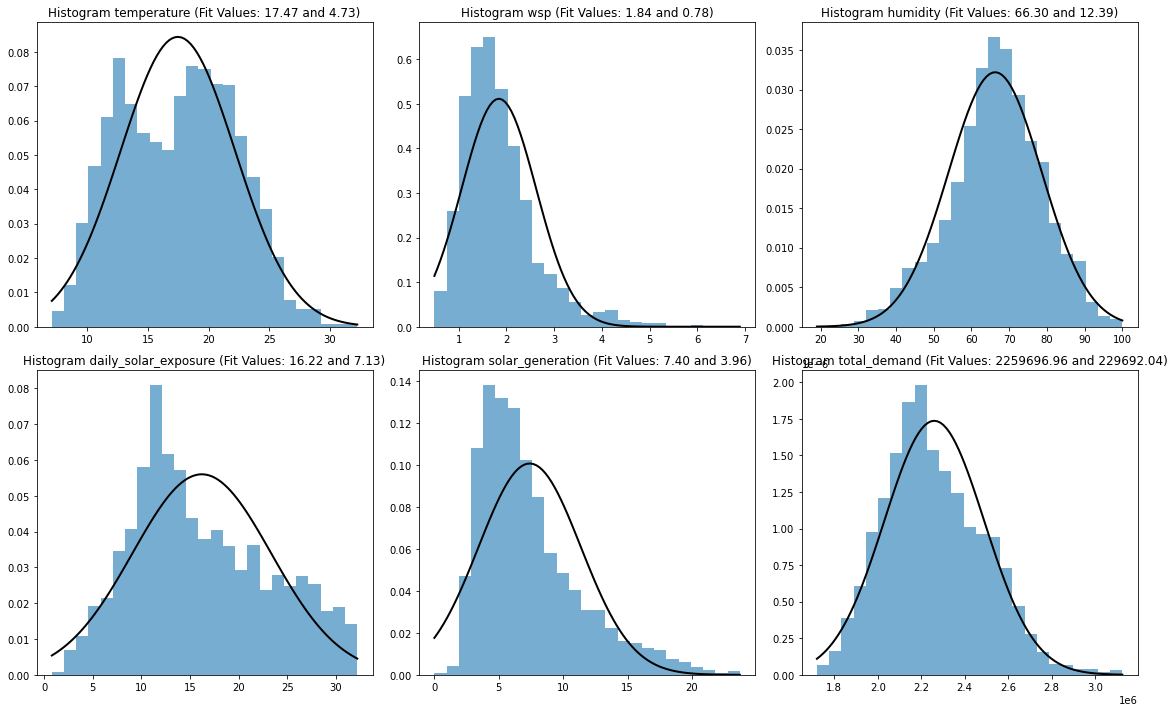

In [20]:
def plot_multiple_histograms(data_list, filename_list):
    
    # Determine the number of histograms to plot
    num_plots = len(data_list)
    
    # Create subplots in a grid
    num_rows = 2
    num_cols = 3
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 10))
    
    for i, (data, filename) in enumerate(zip(data_list, filename_list)):
        # Calculate subplot position
        row = i // num_cols
        col = i % num_cols
        
        # Fit a normal distribution to the data
        mu, std = norm.fit(data)
        
        # Plot the histogram on the appropriate subplot with its own y-axis
        axes[row, col].hist(data, bins=25, density=True, alpha=0.6)
        
        # Plot the PDF
        xmin, xmax = min(data), max(data)
        x = np.linspace(xmin, xmax, 100)
        p = norm.pdf(x, mu, std)
        
        axes[row, col].plot(x, p, 'k', linewidth=2)
        title = "Histogram {} (Fit Values: {:.2f} and {:.2f})".format(filename, mu, std)
        axes[row, col].set_title(title)
        
        print('skewness for {}: {}'.format(filename, skew(data)))
    
    plt.tight_layout()
    plt.show()

data1 = merged_df['temperature']
data2 = merged_df['wsp']
data3 = merged_df['humidity']
data4 = merged_df['daily_solar_exposure']
data5 = merged_df['solar_generation']
data6 = merged_df['total_demand']
filenames = ['temperature', 'wsp', 'humidity', 'daily_solar_exposure', 'solar_generation', 'total_demand']

plot_multiple_histograms([data1, data2, data3, data4, data5, data6], filenames)

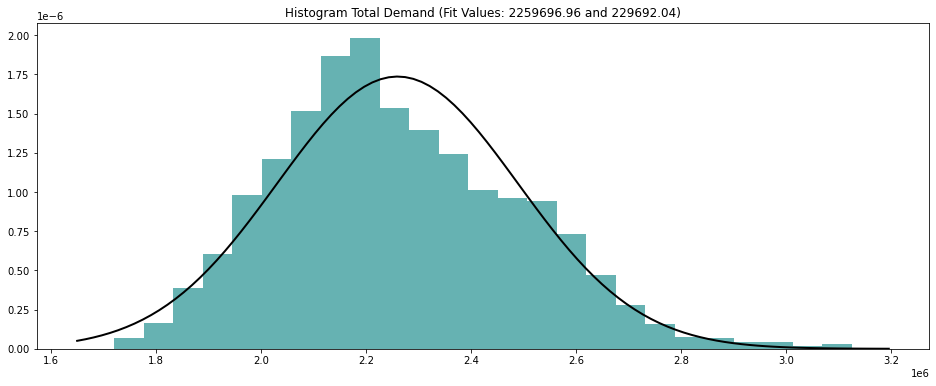

skewness: 0.43249238920646643


In [22]:
def plot_hist(data,filename):
    # https://www.geeksforgeeks.org/how-to-plot-normal-distribution-over-histogram-in-python/
    # Fit a normal distribution to
    # the data:
    # mean and standard deviation
    mu, std = norm.fit(data) 

    # Plot the histogram.
    plt.figure(figsize=(16, 6))
    plt.hist(data, bins=25, density=True, alpha=0.6, color='teal')

    # Plot the PDF.
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)

    plt.plot(x, p, 'k', linewidth=2)
    title = "Histogram "+filename+" (Fit Values: {:.2f} and {:.2f})".format(mu, std)
    plt.title(title)
    name = 'Histogram_'+filename
    plt.savefig(name)
    plt.show()
    
    print( 'skewness: {}'.format( skew(data) ))
    
plot_hist(merged_df['total_demand'],'Total Demand')

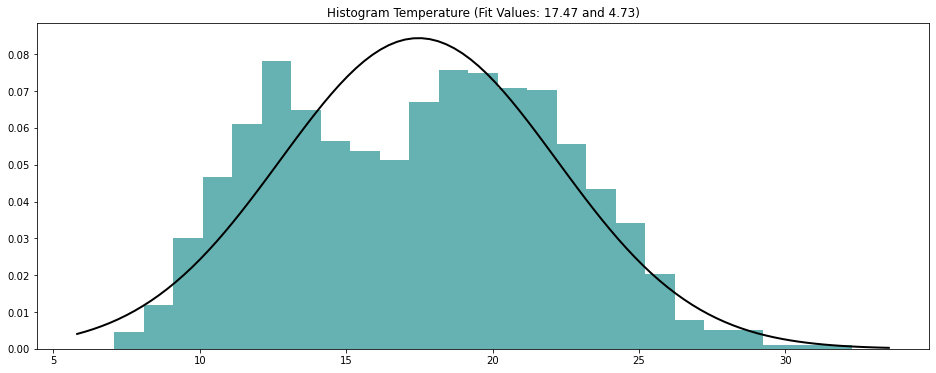

skewness: 0.07923251356807465


In [17]:
plot_hist(merged_df['temperature'],'Temperature')

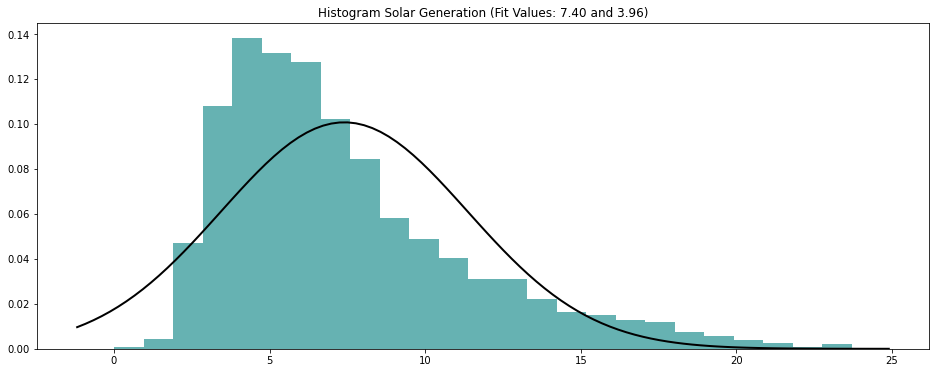

skewness: 1.2076357508596616


In [18]:
plot_hist(merged_df['solar_generation'],'Solar Generation')

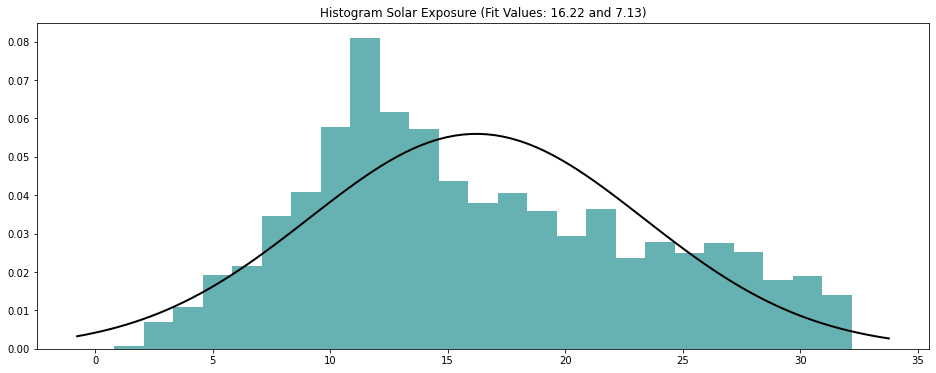

skewness: 0.39592832973558656


In [19]:
plot_hist(merged_df['daily_solar_exposure'],'Solar Exposure')

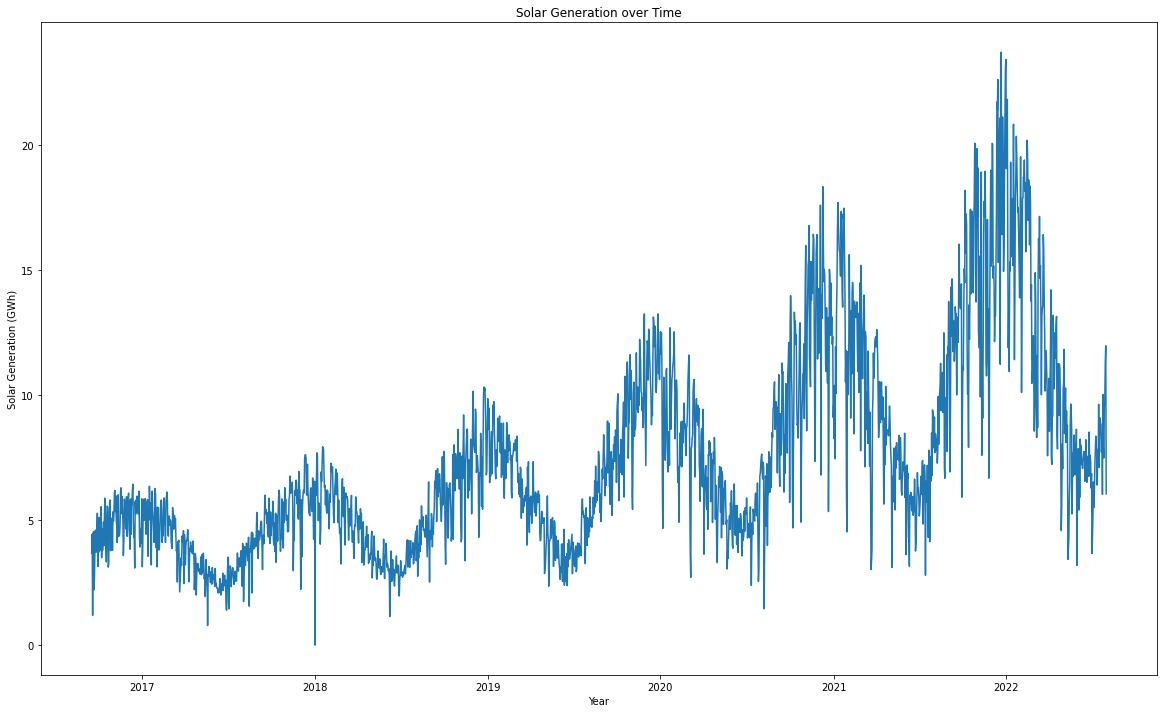

In [23]:
# EDA - Solar Generation over Time

plt.figure(figsize=(20,12))
ax = sns.lineplot(data=merged_df, x='date', y='solar_generation')

ax.set_xlabel('Year')
ax.set_ylabel('Solar Generation (GWh)')
plt.title('Solar Generation over Time')
plt.show()

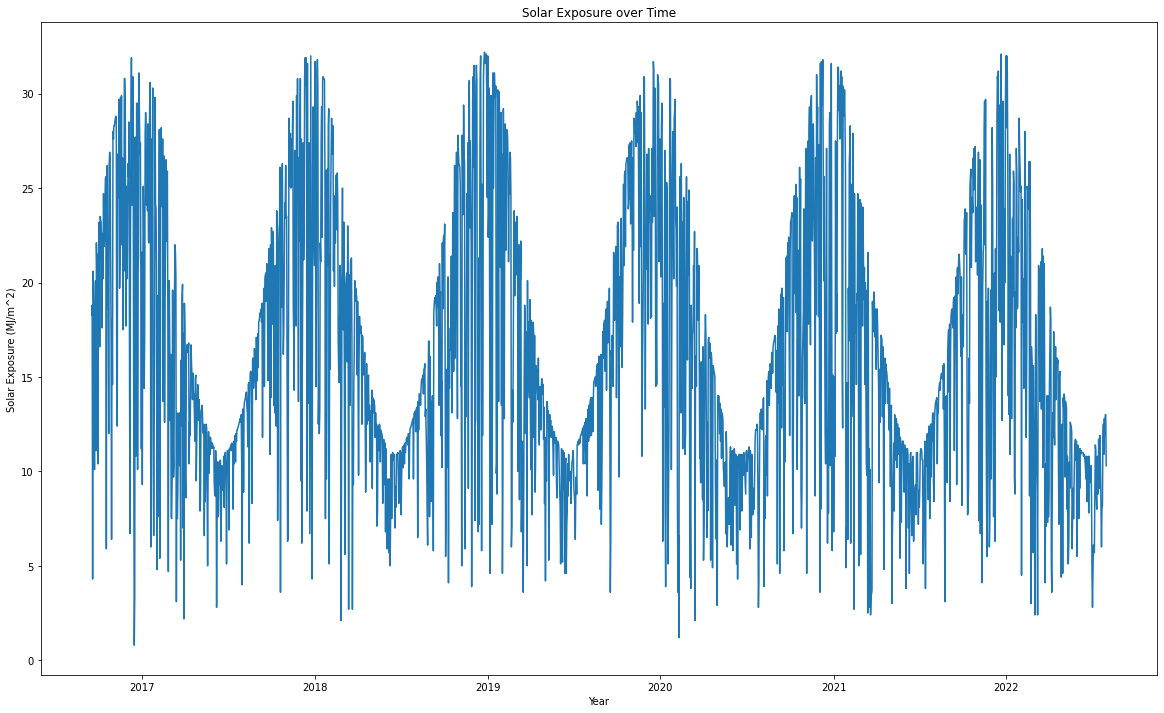

In [24]:
# EDA - Solar Exposure over Time

plt.figure(figsize=(20,12))
ax = sns.lineplot(data=merged_df, x='date', y='daily_solar_exposure')

ax.set_xlabel('Year')
ax.set_ylabel('Solar Exposure (MJ/m^2)')
plt.title('Solar Exposure over Time')
plt.show()

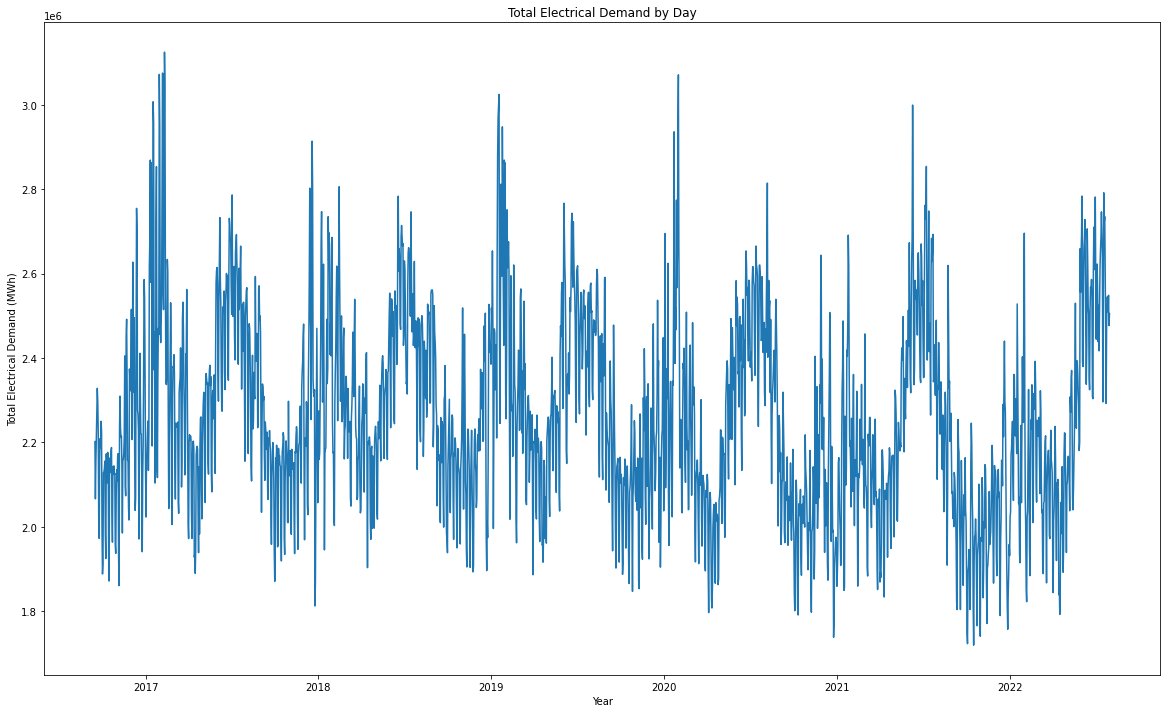

In [20]:
# EDA - Total Electrical over Time

plt.figure(figsize=(20,12))
ax = sns.lineplot(data=merged_df, x='date', y='total_demand')

ax.set_xlabel('Year')
ax.set_ylabel('Total Electrical Demand (MWh)')
plt.title('Total Electrical Demand over Time')
plt.show()

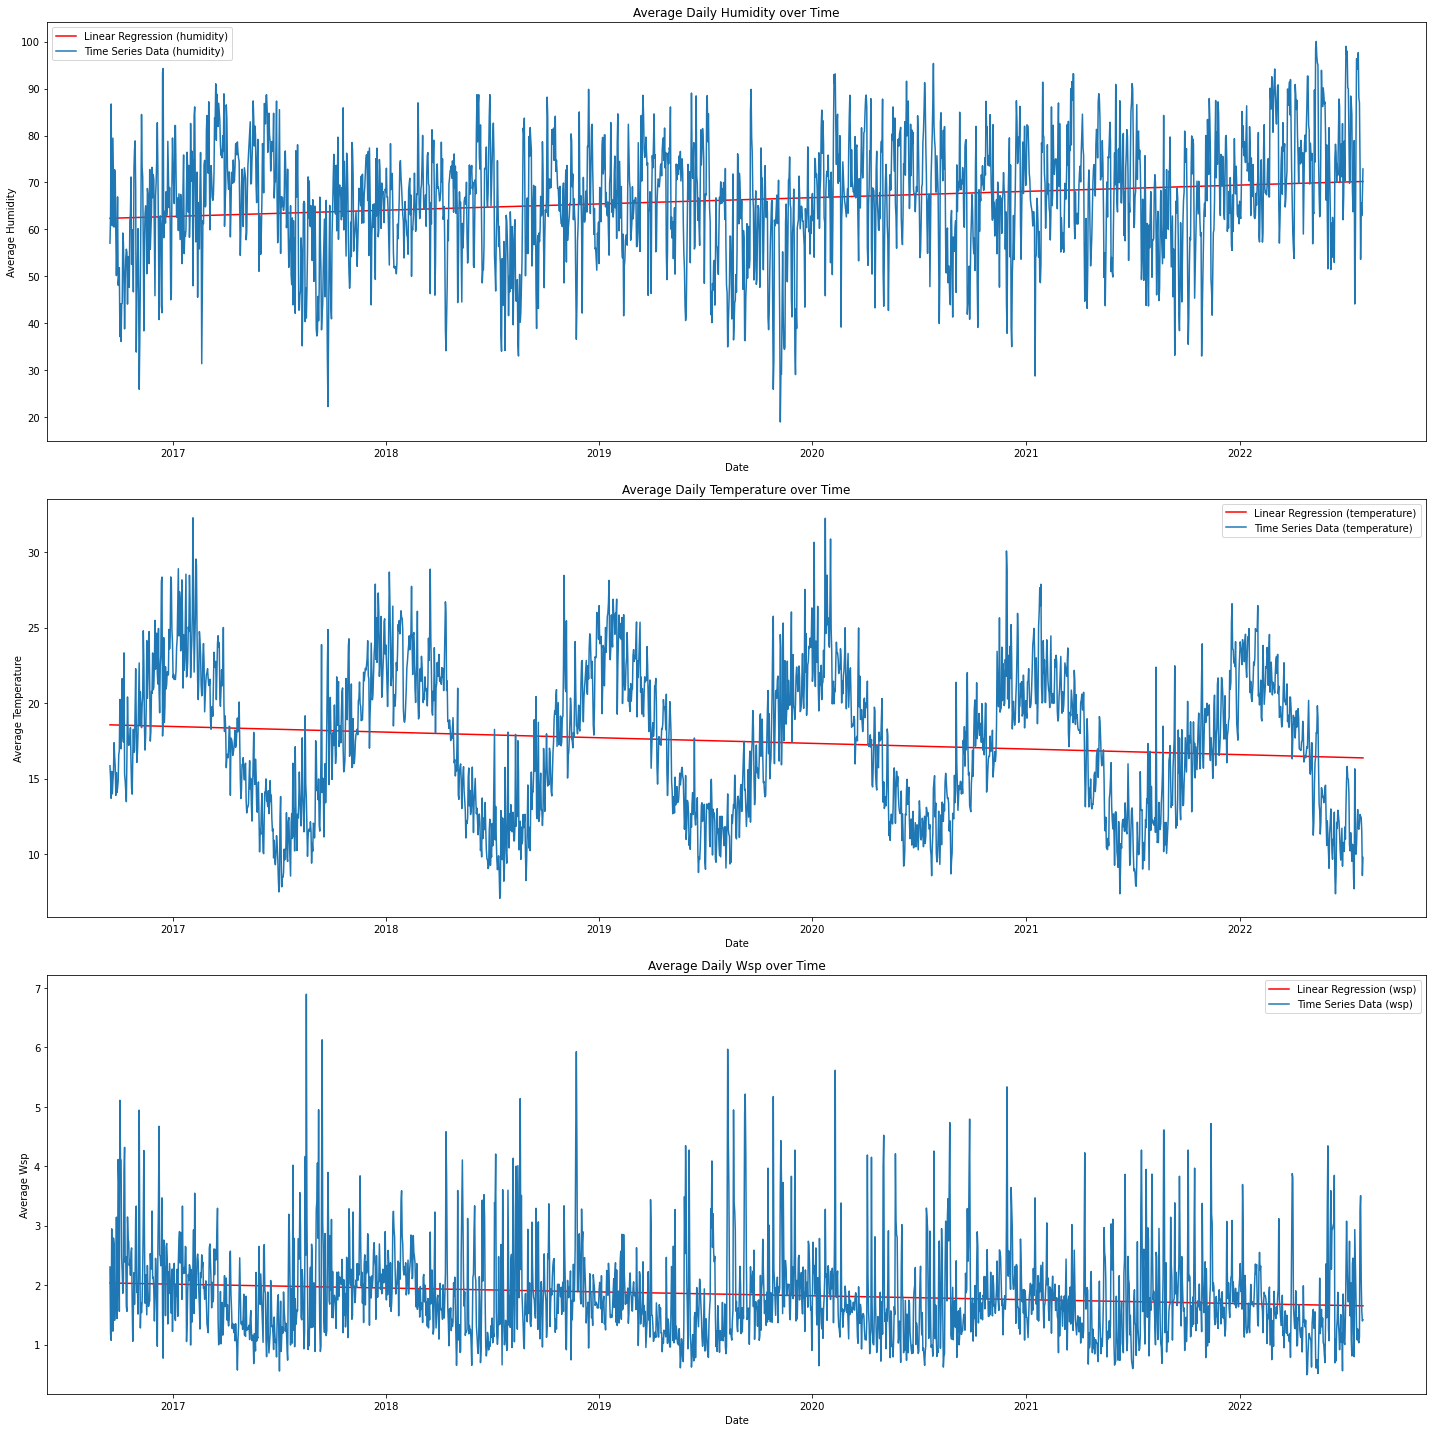

In [34]:
# Create a figure with multiple subplots (you can adjust the number of rows and columns as needed)
num_rows = 3  # Number of rows of subplots
num_cols = 1  # Number of columns of subplots

# Create a new figure with subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 20))

# List of dataframe attributes to fit
attributes_to_fit = ['humidity', 'temperature', 'wsp']  # Add more attributes as needed

# Plot linear regression lines and time series data for each attribute in each subplot
for i, attribute in enumerate(attributes_to_fit):
    # Calculate the linear regression line for the current attribute
    x = np.arange(merged_df['date'].size)
    fit = np.polyfit(x, merged_df[attribute], deg=1)
    fit_function = np.poly1d(fit)
    
    # Determine the subplot position
    row = i % num_rows
    col = i // num_rows
    
    # Plot the linear regression line and time series data in the current subplot
    axs[row].plot(merged_df['date'], fit_function(x), color='red', label=f'Linear Regression ({attribute})')
    axs[row].plot(merged_df['date'], merged_df[attribute], label=f'Time Series Data ({attribute})')
    axs[row].set_xlabel('Date')
    axs[row].set_ylabel(f'Average {attribute.capitalize()}')
    axs[row].set_title(f'Average Daily {attribute.capitalize()} over Time')
    axs[row].legend()  # Add a legend to distinguish the lines

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

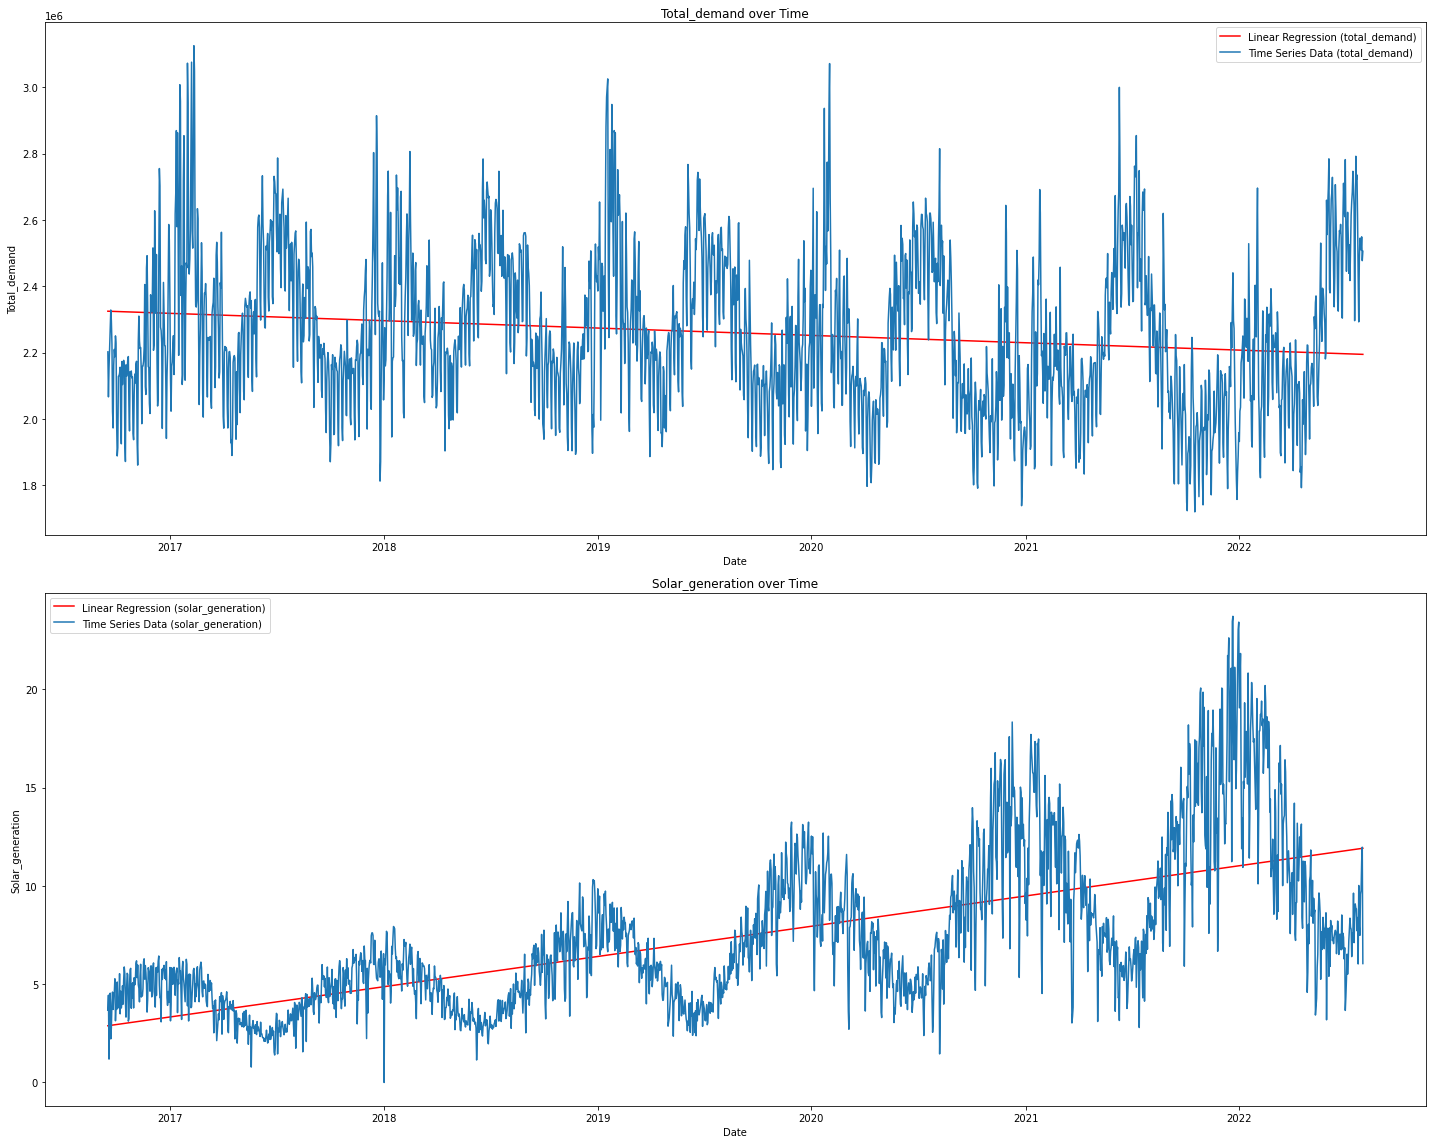

In [38]:
# Create a figure with multiple subplots (you can adjust the number of rows and columns as needed)
num_rows = 2 # Number of rows of subplots
num_cols = 1  # Number of columns of subplots

# Create a new figure with subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 16))

# List of dataframe attributes to fit
attributes_to_fit = ['total_demand', 'solar_generation']  # Add more attributes as needed

# Plot linear regression lines and time series data for each attribute in each subplot
for i, attribute in enumerate(attributes_to_fit):
    # Calculate the linear regression line for the current attribute
    x = np.arange(merged_df['date'].size)
    fit = np.polyfit(x, merged_df[attribute], deg=1)
    fit_function = np.poly1d(fit)
    
    # Determine the subplot position
    row = i % num_rows
    col = i // num_rows
    
    # Plot the linear regression line and time series data in the current subplot
    axs[row].plot(merged_df['date'], fit_function(x), color='red', label=f'Linear Regression ({attribute})')
    axs[row].plot(merged_df['date'], merged_df[attribute], label=f'Time Series Data ({attribute})')
    axs[row].set_xlabel('Date')
    axs[row].set_ylabel(f'{attribute.capitalize()}')
    axs[row].set_title(f'{attribute.capitalize()} over Time')
    axs[row].legend()  # Add a legend to distinguish the lines

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

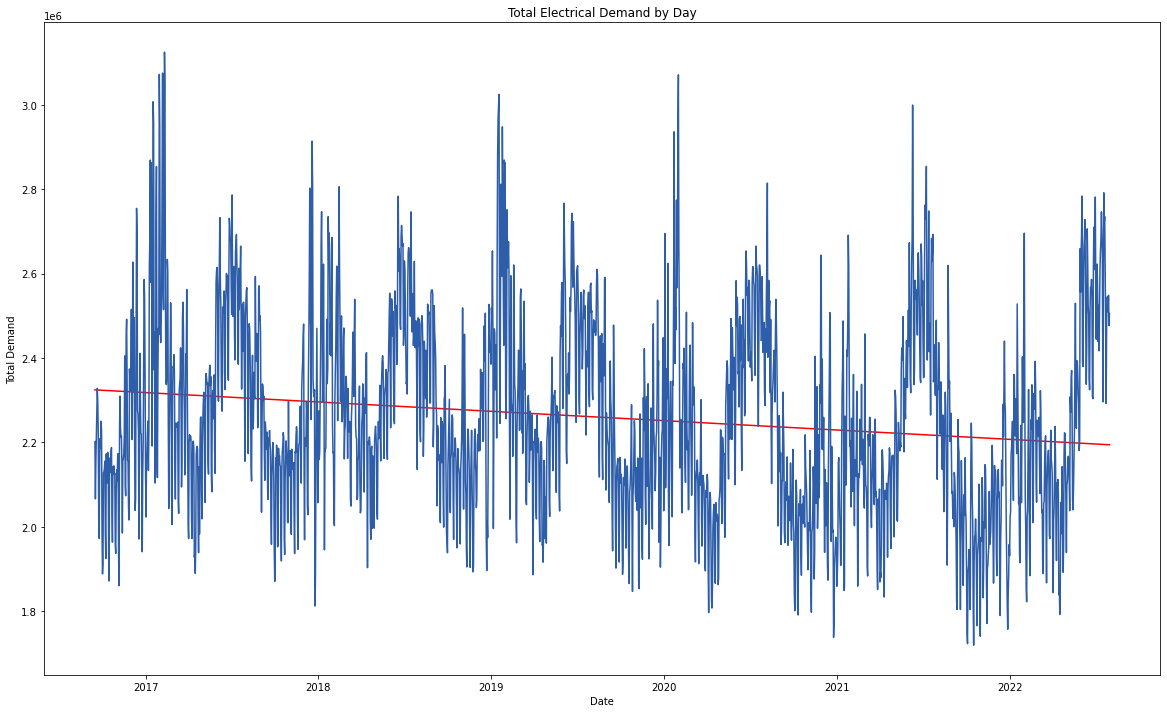

In [21]:
# Plot the Total Electrical Demand with Regression Line
x = np.arange(merged_df['date'].size)
fit = np.polyfit(x, merged_df['total_demand'], deg=1)

#Fit function : y = mx + c [linear regression ]
fit_function = np.poly1d(fit)

#Linear regression plot
plt.figure(figsize=(20,12))
plt.plot(merged_df['date'], fit_function(x),color='red')
#Time series data plot
plt.plot(merged_df['date'], merged_df['total_demand'],color='#2E5EAA')

plt.xlabel('Date')
plt.ylabel('Total Demand')
plt.title('Total Electrical Demand by Day')
plt.show()

Text(0.5, 1.0, 'Total Electrical Demand by Day')

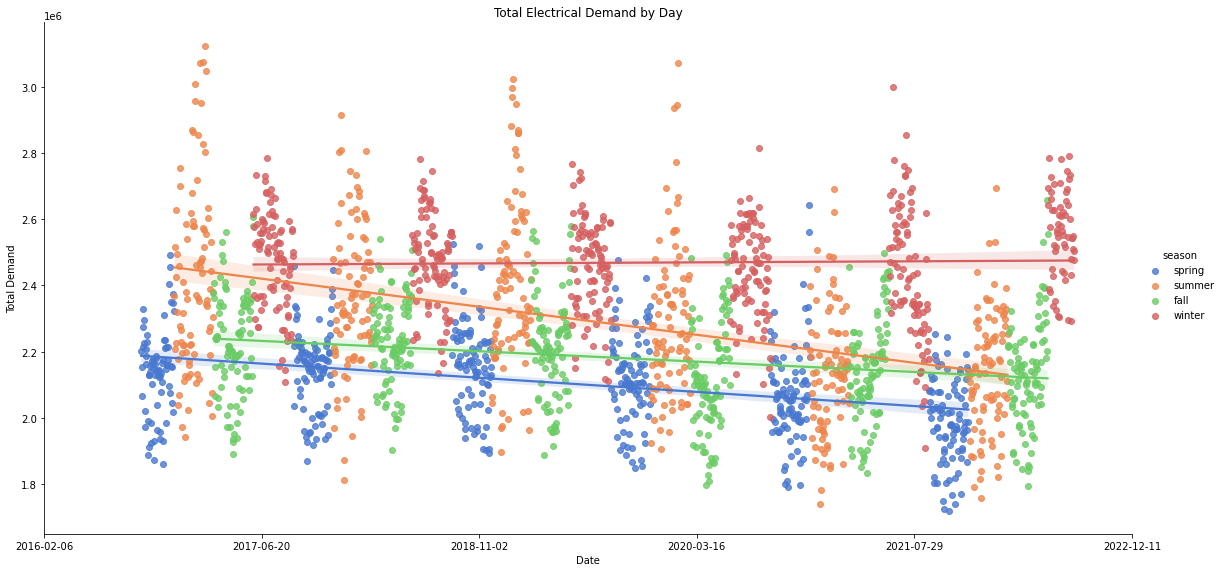

In [43]:
# Plot the Total Electrical Demand with Regression Lines for each season
merged_df['date_ordinal'] = merged_df['date'].apply(lambda x: x.toordinal())
ax=sns.lmplot(data=merged_df, x='date_ordinal', y='total_demand', hue='season', palette='muted', height=8, aspect=2)
xticks = plt.gca().get_xticks()
xticks_dates= [datetime.date.fromordinal(int(x)) for x in xticks]
plt.xticks(xticks, xticks_dates)
plt.xlabel('Date')
plt.ylabel('Total Demand')
plt.title('Total Electrical Demand by Day')



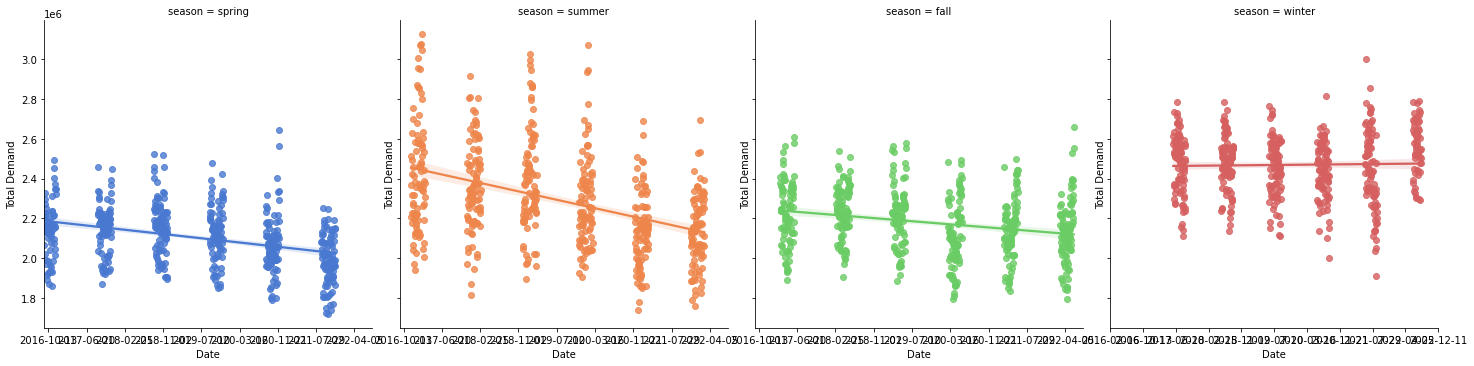

In [23]:
# Plot the Total Electrical Demand with Regression Lines for each season in subplots

ax=sns.lmplot(data=merged_df, x='date_ordinal', y='total_demand', col='season', hue='season', palette='muted')
xticks = plt.gca().get_xticks()
xticks_dates= [datetime.date.fromordinal(int(x)) for x in xticks]
plt.xticks(xticks, xticks_dates)
ax.set(xlabel = 'Date', ylabel = 'Total Demand')

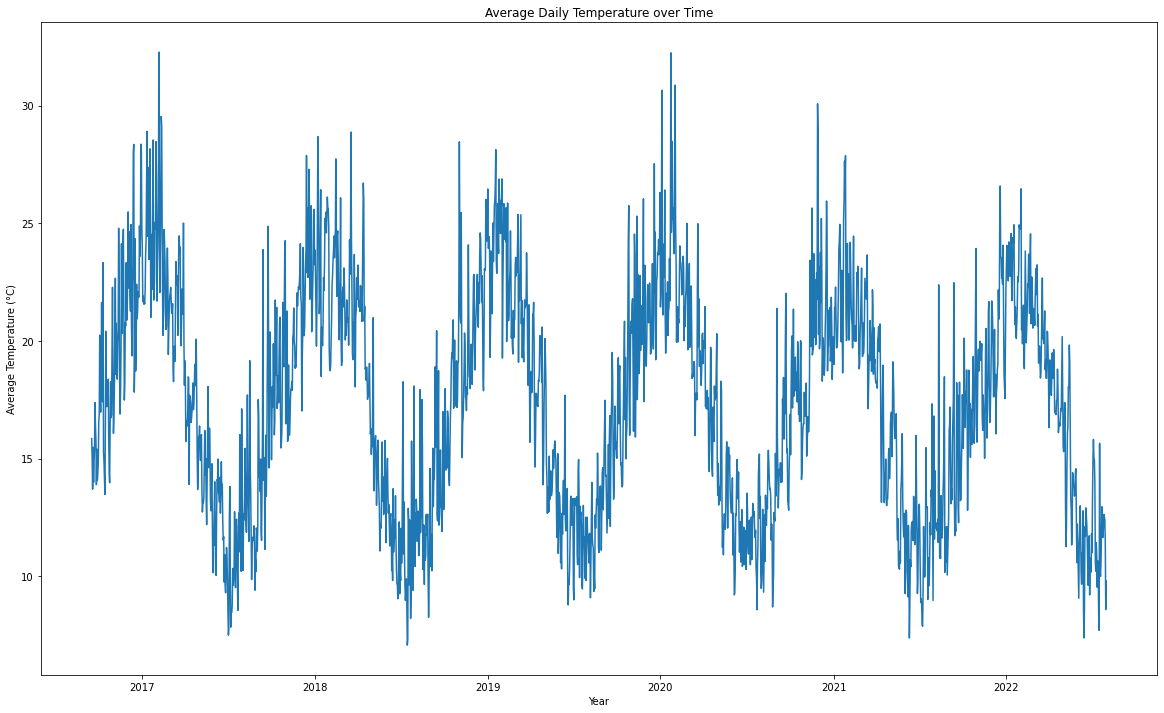

In [26]:
plt.figure(figsize=(20,12))
ax = sns.lineplot(data=merged_df, x='date', y='temperature')

ax.set_xlabel('Year')
ax.set_ylabel('Average Temperature (°C)')
plt.title('Average Daily Temperature over Time')
plt.show()

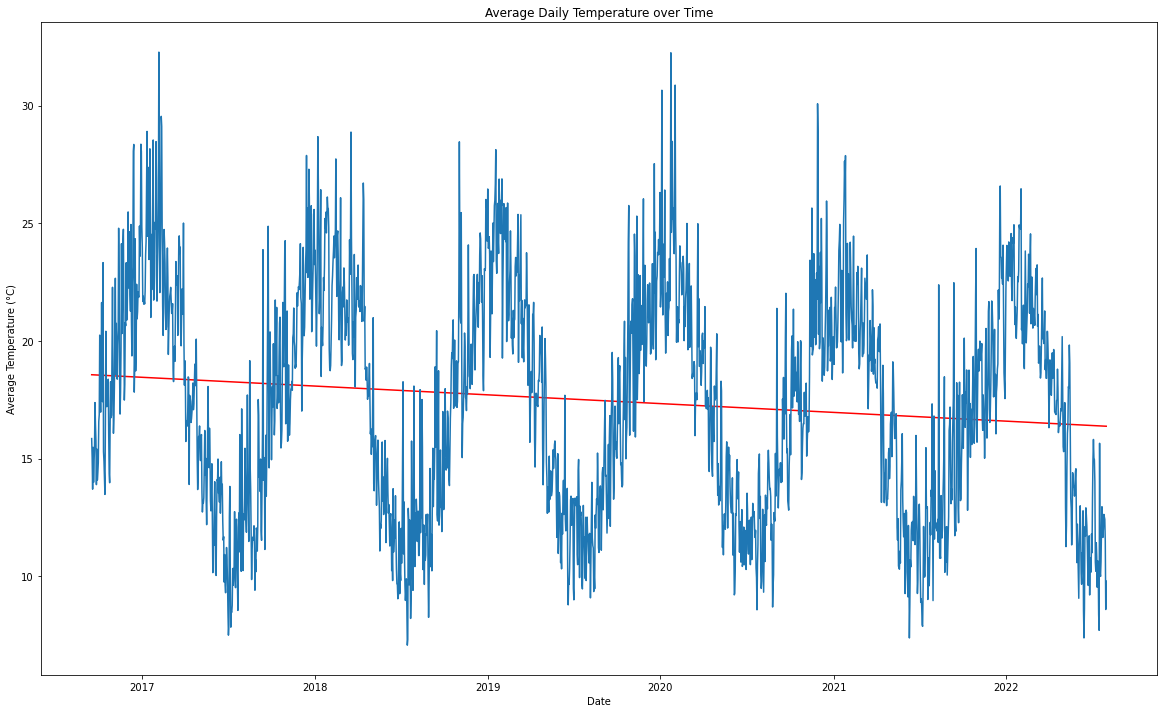

In [27]:
# Plot the Average temperature with Regression Line
x = np.arange(merged_df['date'].size)
fit = np.polyfit(x, merged_df['temperature'], deg=1)

#Fit function : y = mx + c [linear regression ]
fit_function = np.poly1d(fit)

#Linear regression plot
plt.figure(figsize=(20,12))
plt.plot(merged_df['date'], fit_function(x),color='red')
#Time series data plot
plt.plot(merged_df['date'], merged_df['temperature'])

plt.xlabel('Date')
plt.ylabel('Average Temperature (°C)')
plt.title('Average Daily Temperature over Time')
plt.show()

Text(0.5, 1.0, 'Average Temperature by Day')

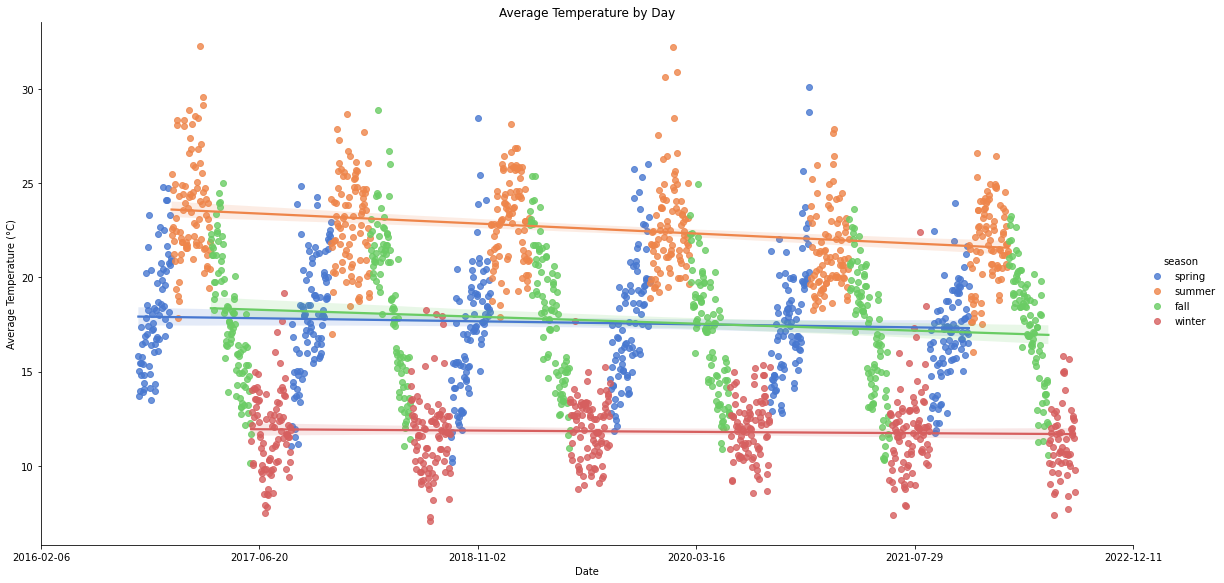

In [44]:
# Plot the Average Temperature with Regression Lines for each season

ax=sns.lmplot(data=merged_df, x='date_ordinal', y='temperature', hue='season', palette='muted', height=8, aspect=2)
xticks = plt.gca().get_xticks()
xticks_dates= [datetime.date.fromordinal(int(x)) for x in xticks]
plt.xticks(xticks, xticks_dates)
plt.xlabel('Date')
plt.ylabel('Average Temperature (°C)')
plt.title('Average Temperature by Day')



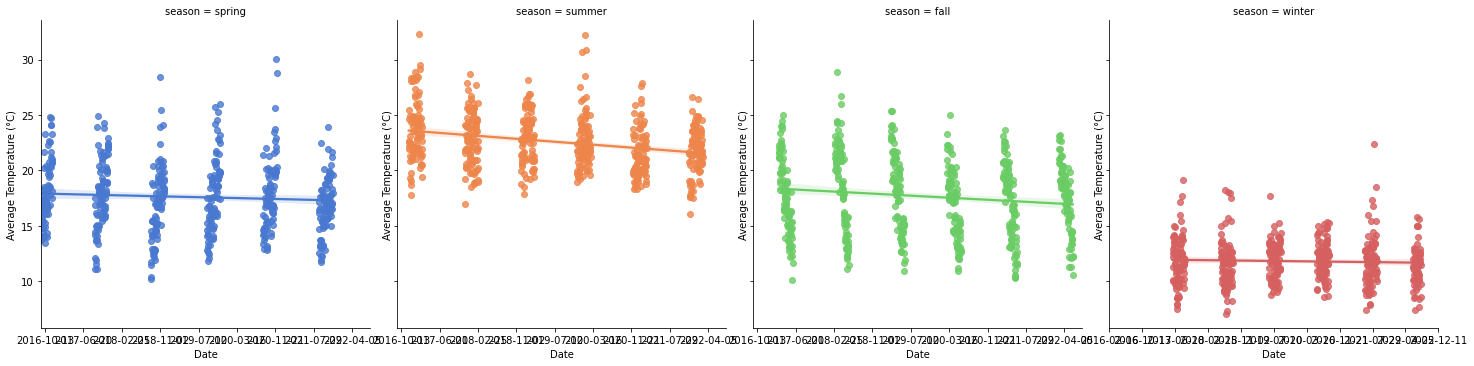

In [27]:
# Plot the Average temperature with Regression Lines for each season in subplots

ax=sns.lmplot(data=merged_df, x='date_ordinal', y='temperature', col='season', hue='season', palette='muted')
xticks = plt.gca().get_xticks()
xticks_dates= [datetime.date.fromordinal(int(x)) for x in xticks]
plt.xticks(xticks, xticks_dates)
ax.set(xlabel = 'Date', ylabel = 'Average Temperature (°C)')


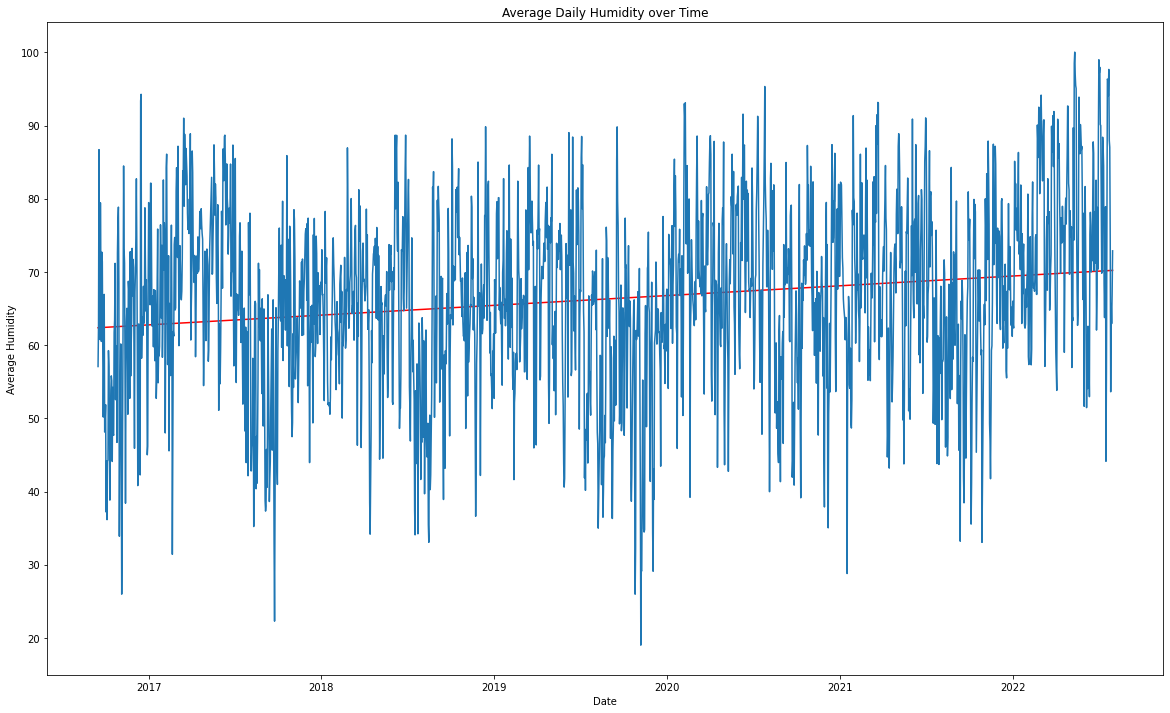

In [40]:
# Plot the Average humidity with Regression Line
x = np.arange(merged_df['date'].size)
fit = np.polyfit(x, merged_df['humidity'], deg=1)

#Fit function : y = mx + c [linear regression ]
fit_function = np.poly1d(fit)

#Linear regression plot
plt.figure(figsize=(20,12))
plt.plot(merged_df['date'], fit_function(x),color='red')
#Time series data plot
plt.plot(merged_df['date'], merged_df['humidity'])

plt.xlabel('Date')
plt.ylabel('Average Humidity')
plt.title('Average Daily Humidity over Time')
plt.show()

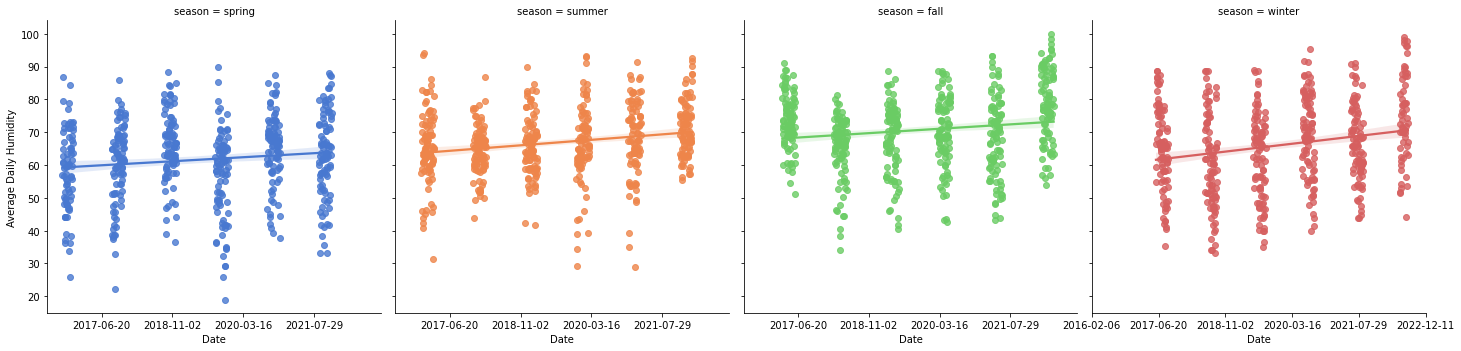

In [46]:
# Plot the Average Daily Humidity with Regression Lines for each season in subplots

ax=sns.lmplot(data=merged_df, x='date_ordinal', y='humidity', col='season', hue='season', palette='muted')
xticks = plt.gca().get_xticks()
xticks_dates= [datetime.date.fromordinal(int(x)) for x in xticks]
plt.xticks(xticks, xticks_dates)
ax.set(xlabel = 'Date', ylabel = 'Average Daily Humidity')


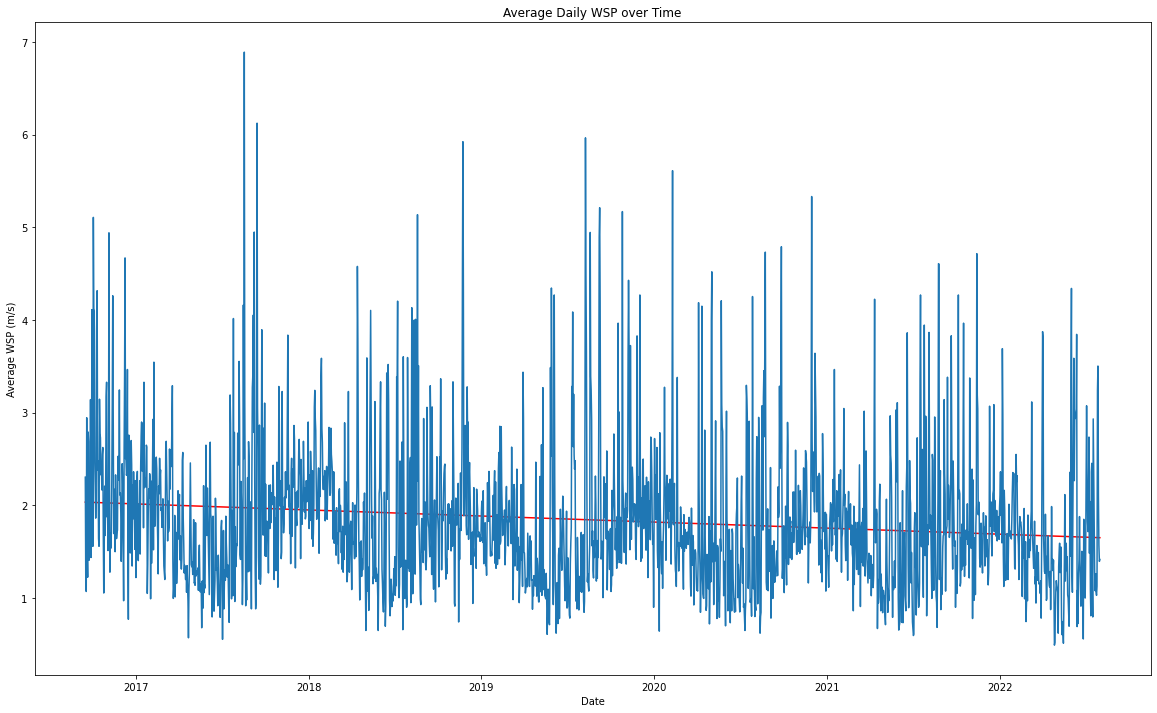

In [47]:
# Plot the Average wsp with Regression Line
x = np.arange(merged_df['date'].size)
fit = np.polyfit(x, merged_df['wsp'], deg=1)

#Fit function : y = mx + c [linear regression ]
fit_function = np.poly1d(fit)

#Linear regression plot
plt.figure(figsize=(20,12))
plt.plot(merged_df['date'], fit_function(x),color='red')
#Time series data plot
plt.plot(merged_df['date'], merged_df['wsp'])

plt.xlabel('Date')
plt.ylabel('Average WSP (m/s)')
plt.title('Average Daily WSP over Time')
plt.show()

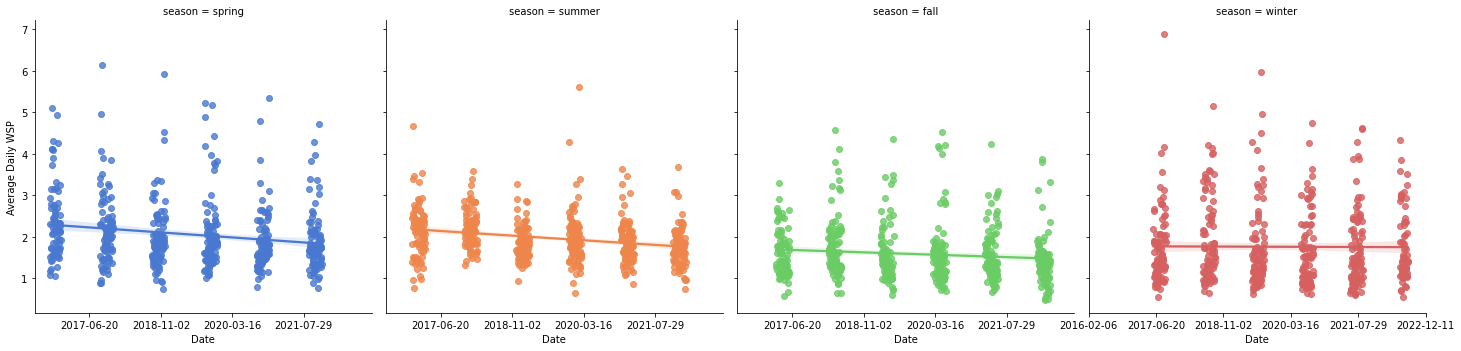

In [48]:
# Plot the Average Daily Humidity with Regression Lines for each season in subplots

ax=sns.lmplot(data=merged_df, x='date_ordinal', y='wsp', col='season', hue='season', palette='muted')
xticks = plt.gca().get_xticks()
xticks_dates= [datetime.date.fromordinal(int(x)) for x in xticks]
plt.xticks(xticks, xticks_dates)
ax.set(xlabel = 'Date', ylabel = 'Average Daily WSP')


In [49]:
df = merged_df
df['date'] = pd.to_datetime(df['date'])

# Extract day and month
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month



In [ ]:
# Group by month and day and calculate average temperature
avg_temp = df.groupby(['month', 'day'])['temperature'].mean().reset_index()

# Create a temporary date column with a constant year (like 2000) and then extract day_of_year
avg_temp['temp_date'] = pd.to_datetime('2000-' + avg_temp['month'].astype(str) + '-' + avg_temp['day'].astype(str))
avg_temp['day_of_year'] = avg_temp['temp_date'].dt.dayofyear
avg_temp.drop('temp_date', axis=1, inplace=True)

# Plot
plt.figure(figsize=(20, 12))
sns.lineplot(data=avg_temp, x='day_of_year', y='temperature')
plt.xlabel('Day of Year')
plt.ylabel('Average Temperature (°C)')
plt.title('Average Daily Temperature by Day of Year')
plt.show()

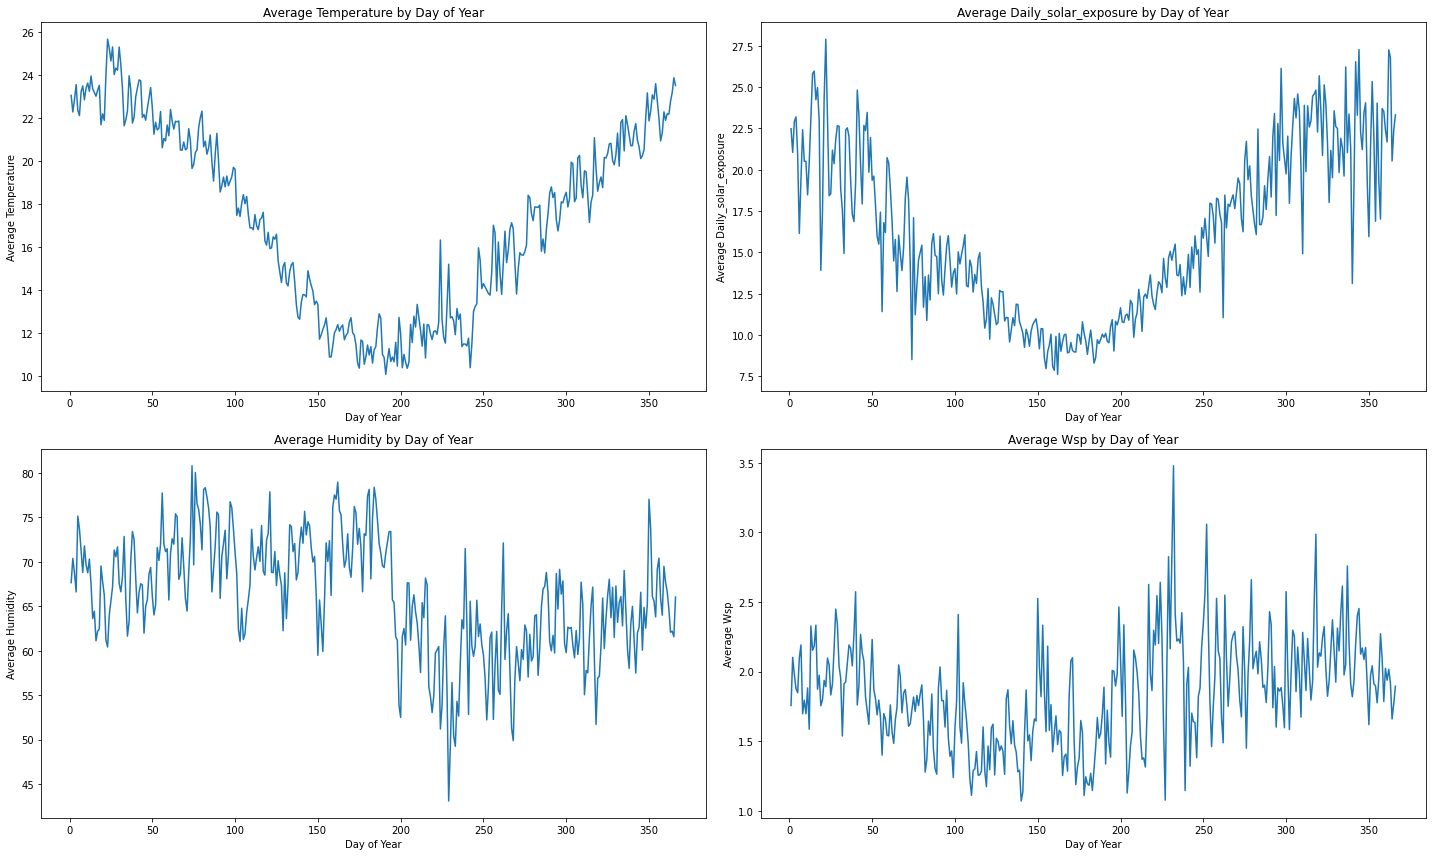

In [60]:
# List of dataframe attributes to plot
attributes_to_plot = ['temperature', 'daily_solar_exposure','humidity', 'wsp']  # Add more attributes as needed

# Create a figure with multiple subplots (you can adjust the number of rows and columns as needed)
num_rows = 2
num_cols = 2  # Number of columns of subplots

# Create a new figure with subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 6 * num_rows))

# Flatten the axs array to simplify indexing
axs = axs.flatten()

# Plot different attributes in each subplot
for i, attribute in enumerate(attributes_to_plot):
    # Group by month and day and calculate the average for the current attribute
    avg_attribute = df.groupby(['month', 'day'])[attribute].mean().reset_index()
    
    # Create a temporary date column with a constant year (like 2000) and then extract day_of_year
    avg_attribute['temp_date'] = pd.to_datetime('2000-' + avg_attribute['month'].astype(str) + '-' + avg_attribute['day'].astype(str))
    avg_attribute['day_of_year'] = avg_attribute['temp_date'].dt.dayofyear
    avg_attribute.drop('temp_date', axis=1, inplace=True)
    
    # Plot the current attribute in the current subplot
    axs[i].plot(avg_attribute['day_of_year'], avg_attribute[attribute])
    axs[i].set_xlabel('Day of Year')
    axs[i].set_ylabel(f'Average {attribute.capitalize()}')
    axs[i].set_title(f'Average {attribute.capitalize()} by Day of Year')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()


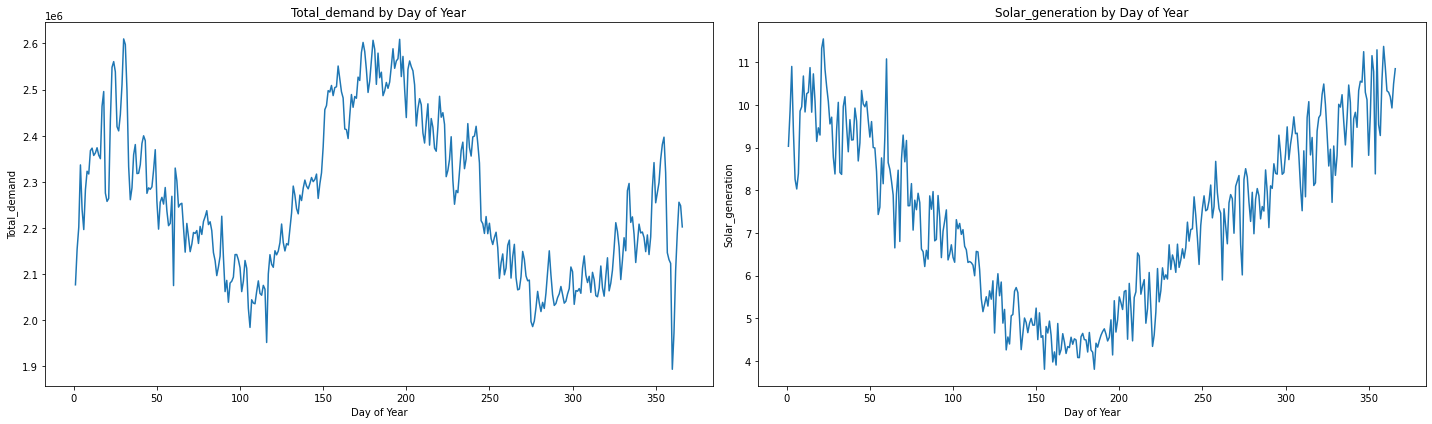

In [62]:

# List of dataframe attributes to plot
attributes_to_plot = ['total_demand', 'solar_generation']  # Add more attributes as needed

# Create a figure with multiple subplots (you can adjust the number of rows and columns as needed)
num_rows = 1
num_cols = 2  # Number of columns of subplots

# Create a new figure with subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 6 * num_rows))

# Flatten the axs array to simplify indexing
axs = axs.flatten()

# Plot different attributes in each subplot
for i, attribute in enumerate(attributes_to_plot):
    # Group by month and day and calculate the average for the current attribute
    avg_attribute = df.groupby(['month', 'day'])[attribute].mean().reset_index()
    
    # Create a temporary date column with a constant year (like 2000) and then extract day_of_year
    avg_attribute['temp_date'] = pd.to_datetime('2000-' + avg_attribute['month'].astype(str) + '-' + avg_attribute['day'].astype(str))
    avg_attribute['day_of_year'] = avg_attribute['temp_date'].dt.dayofyear
    avg_attribute.drop('temp_date', axis=1, inplace=True)
    
    # Plot the current attribute in the current subplot
    axs[i].plot(avg_attribute['day_of_year'], avg_attribute[attribute])
    axs[i].set_xlabel('Day of Year')
    axs[i].set_ylabel(f'{attribute.capitalize()}')
    axs[i].set_title(f'{attribute.capitalize()} by Day of Year')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()


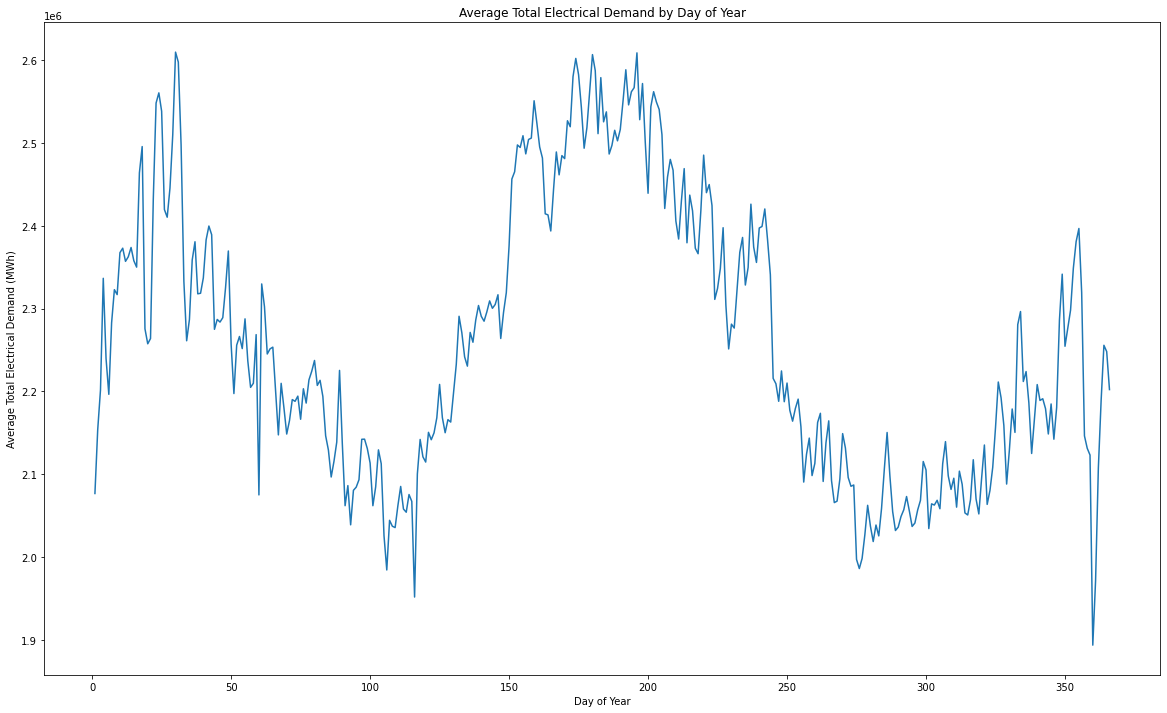

In [29]:
avg_demand = df.groupby(['month', 'day'])['total_demand'].mean().reset_index()

avg_demand['temp_date'] = pd.to_datetime('2000-' + avg_demand['month'].astype(str) + '-' + avg_demand['day'].astype(str))
avg_demand['day_of_year'] = avg_demand['temp_date'].dt.dayofyear
avg_demand.drop('temp_date', axis=1, inplace=True)

plt.figure(figsize=(20, 12))
sns.lineplot(data=avg_demand, x='day_of_year', y='total_demand')
plt.xlabel('Day of Year')
plt.ylabel('Average Total Electrical Demand (MWh)')
plt.title('Average Total Electrical Demand by Day of Year')
plt.show()

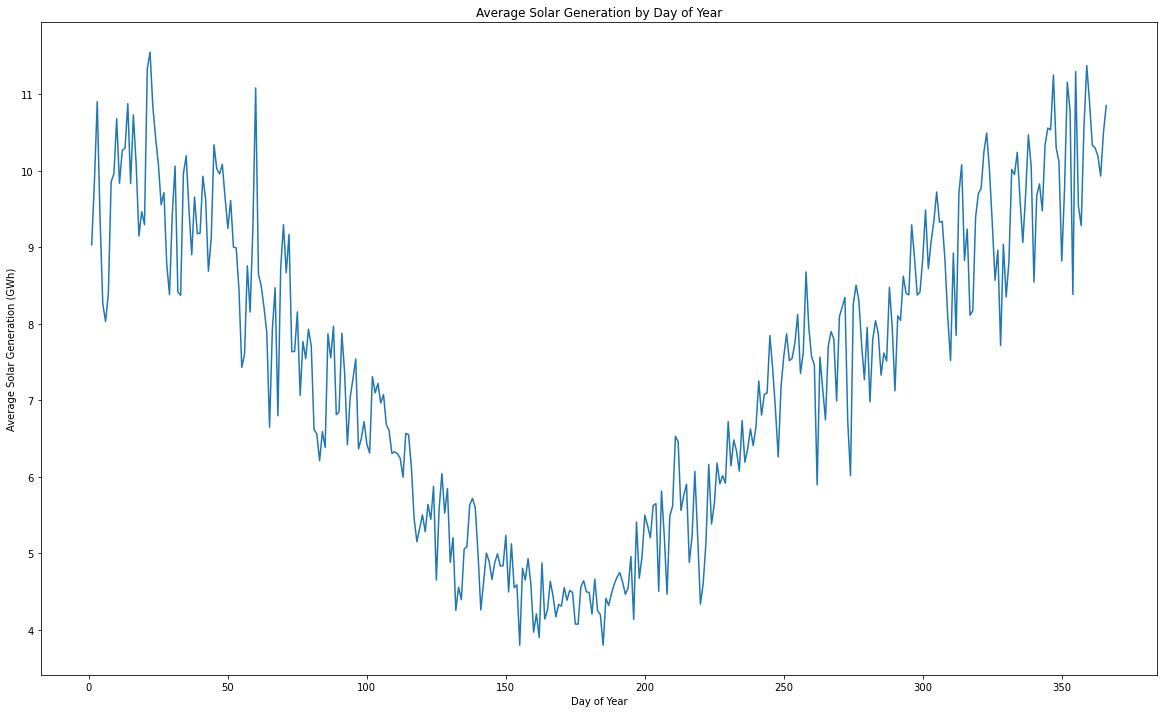

In [30]:
avg_solar_gen = df.groupby(['month', 'day'])['solar_generation'].mean().reset_index()

avg_solar_gen['temp_date'] = pd.to_datetime('2000-' + avg_solar_gen['month'].astype(str) + '-' + avg_solar_gen['day'].astype(str))
avg_solar_gen['day_of_year'] = avg_solar_gen['temp_date'].dt.dayofyear
avg_solar_gen.drop('temp_date', axis=1, inplace=True)

plt.figure(figsize=(20, 12))
sns.lineplot(data=avg_solar_gen, x='day_of_year', y='solar_generation')
plt.xlabel('Day of Year')
plt.ylabel('Average Solar Generation (GWh)')
plt.title('Average Solar Generation by Day of Year')
plt.show()

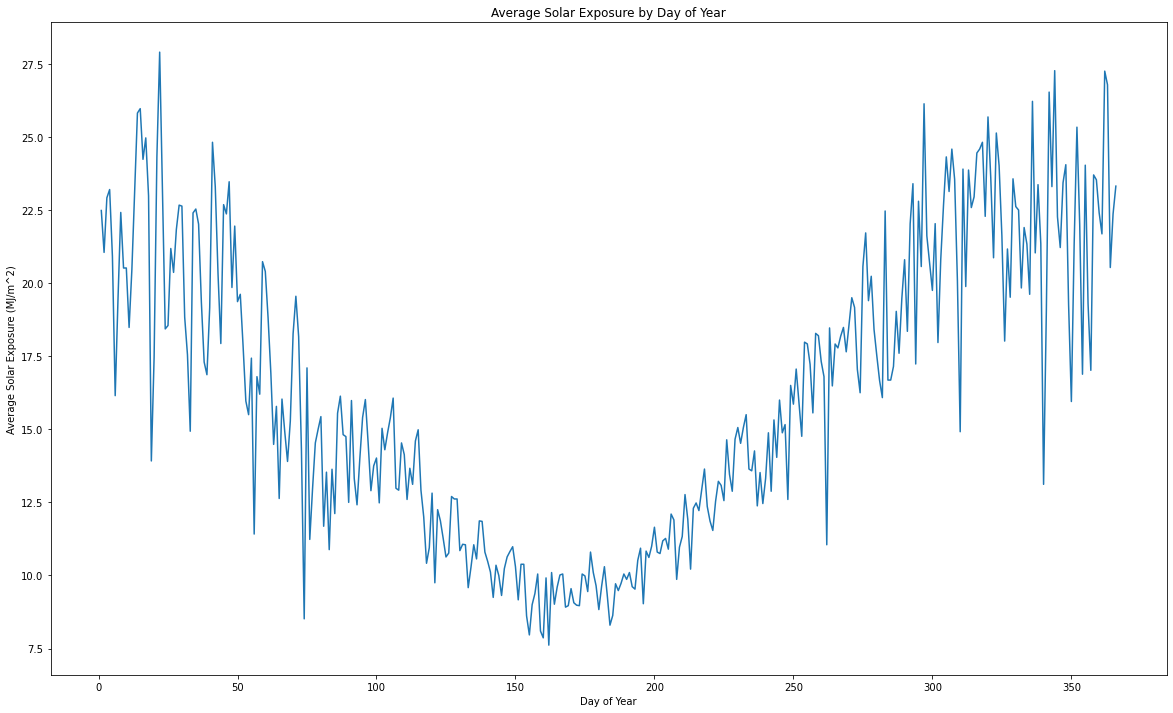

In [31]:
avg_daily_solar_exp = df.groupby(['month', 'day'])['daily_solar_exposure'].mean().reset_index()

# Create a temporary date column with a constant year (like 2000) to extract day_of_year
avg_daily_solar_exp['temp_date'] = pd.to_datetime('2000-' + avg_daily_solar_exp['month'].astype(str) + '-' + avg_daily_solar_exp['day'].astype(str))
avg_daily_solar_exp['day_of_year'] = avg_daily_solar_exp['temp_date'].dt.dayofyear
avg_daily_solar_exp.drop('temp_date', axis=1, inplace=True)

# Plot
plt.figure(figsize=(20, 12))
sns.lineplot(data=avg_daily_solar_exp, x='day_of_year', y='daily_solar_exposure')
plt.xlabel('Day of Year')
plt.ylabel('Average Solar Exposure (MJ/m^2)')
plt.title('Average Solar Exposure by Day of Year')
plt.show()

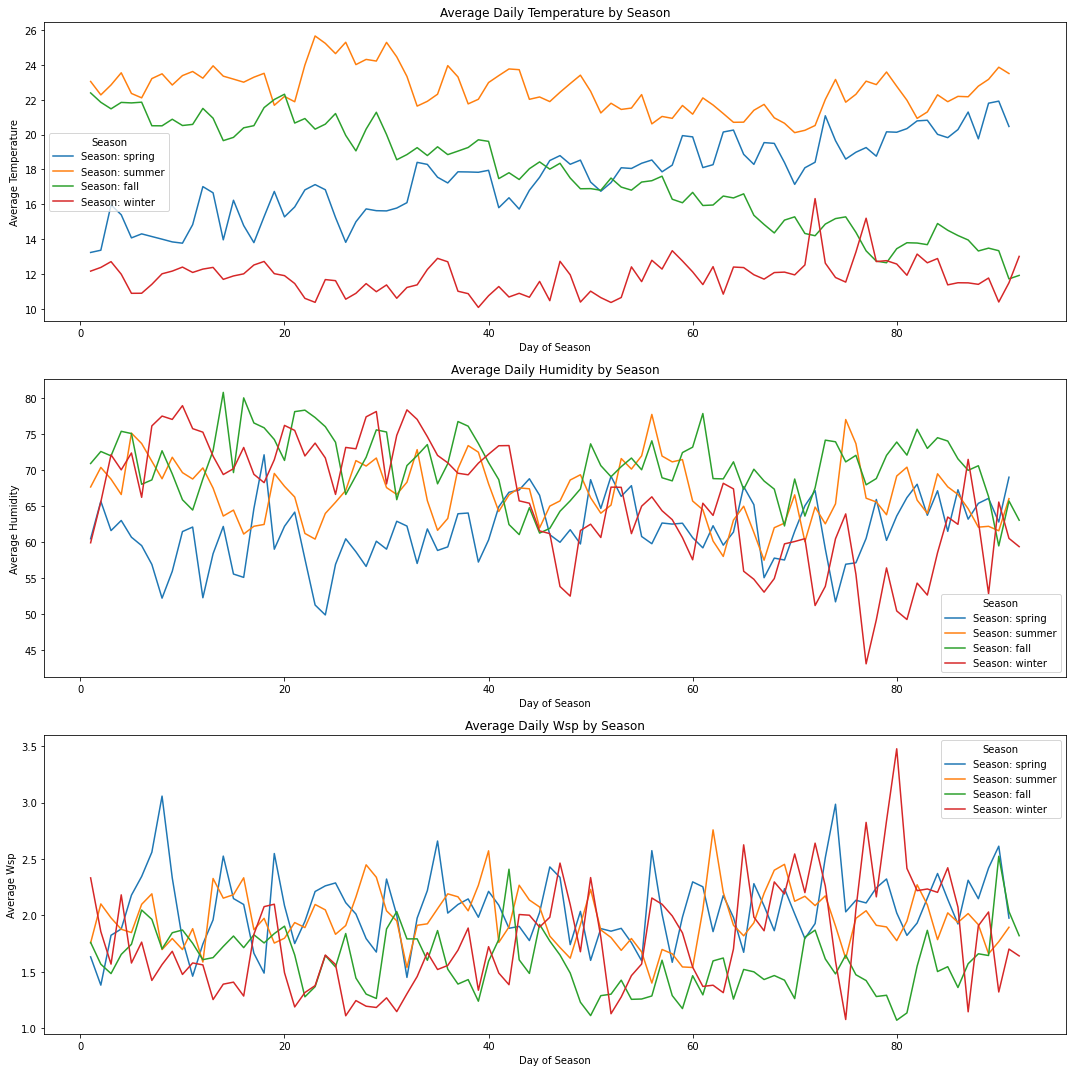

In [77]:
# List of dataframe attributes to plot
attributes_to_plot = ['temperature', 'humidity', 'wsp']  # Add more attributes as needed

# Create a new figure with multiple subplots
fig, axs = plt.subplots(len(attributes_to_plot), 1, figsize=(15, 5 * len(attributes_to_plot)))

# Iterate through the attributes
for i, attribute in enumerate(attributes_to_plot):
    # Group by season, month, day, and day_of_season and calculate the average for the current attribute
    avg_attribute = df.groupby(['season', 'month', 'day'])[attribute].mean().reset_index()

    # Create a sequence of days for each season
    avg_attribute['day_of_season'] = avg_attribute.groupby('season').cumcount() + 1

    # Iterate through seasons and plot on the same subplot
    seasons = df['season'].unique()
    for season in seasons:
        season_data = avg_attribute[avg_attribute['season'] == season]
        axs[i].plot(season_data['day_of_season'], season_data[attribute], label=f'Season: {season}')

    axs[i].set_xlabel('Day of Season')
    axs[i].set_ylabel(f'Average {attribute.capitalize()}')
    axs[i].set_title(f'Average Daily {attribute.capitalize()} by Season')
    axs[i].legend(title='Season')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

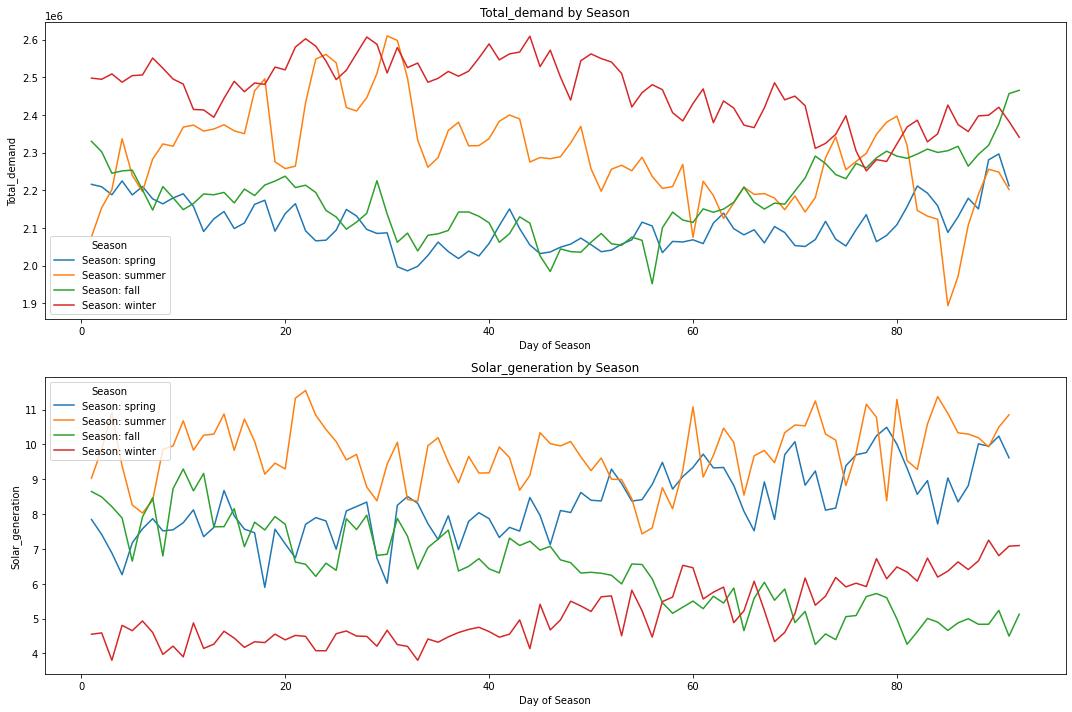

In [80]:
# List of dataframe attributes to plot
attributes_to_plot = ['total_demand','solar_generation']  # Add more attributes as needed

# Create a new figure with multiple subplots
fig, axs = plt.subplots(len(attributes_to_plot), 1, figsize=(15, 5 * len(attributes_to_plot)))

# Iterate through the attributes
for i, attribute in enumerate(attributes_to_plot):
    # Group by season, month, day, and day_of_season and calculate the average for the current attribute
    avg_attribute = df.groupby(['season', 'month', 'day'])[attribute].mean().reset_index()

    # Create a sequence of days for each season
    avg_attribute['day_of_season'] = avg_attribute.groupby('season').cumcount() + 1

    # Iterate through seasons and plot on the same subplot
    seasons = df['season'].unique()
    for season in seasons:
        season_data = avg_attribute[avg_attribute['season'] == season]
        axs[i].plot(season_data['day_of_season'], season_data[attribute], label=f'Season: {season}')

    axs[i].set_xlabel('Day of Season')
    axs[i].set_ylabel(f'{attribute.capitalize()}')
    axs[i].set_title(f'{attribute.capitalize()} by Season')
    axs[i].legend(title='Season')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

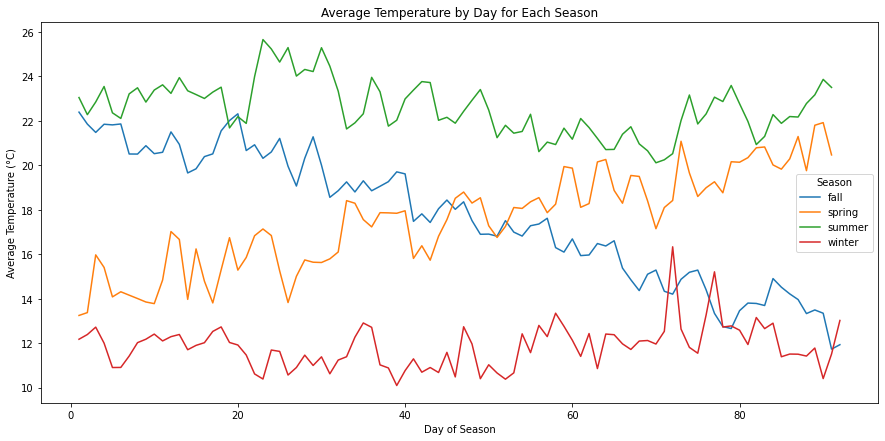

In [114]:
df = merged_df
df['date'] = pd.to_datetime(df['date'])

# Extract month, day, and season
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month

# Group by season, month, and day and then calculate average temperature
avg_temp = df.groupby(['season', 'month', 'day'])['temperature'].mean().reset_index()

# Create a sequence of days for each season
avg_temp['day_of_season'] = avg_temp.groupby('season').cumcount() + 1

# Plot
plt.figure(figsize=(15, 7))
sns.lineplot(data=avg_temp, x='day_of_season', y='temperature', hue='season')
plt.xlabel('Day of Season')
plt.ylabel('Average Temperature (°C)')
plt.title('Average Temperature by Day for Each Season')
plt.legend(title='Season')
plt.show()

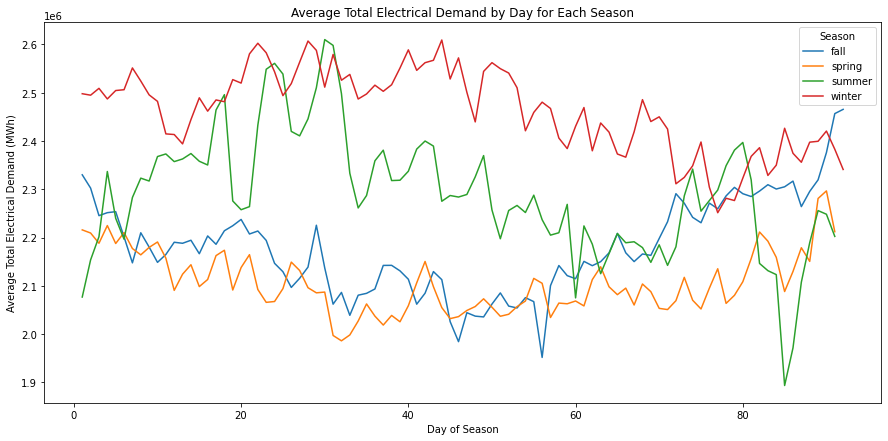

In [66]:
avg_demand = df.groupby(['season', 'month', 'day'])['total_demand'].mean().reset_index()

# Create a sequence of days for each season
avg_demand['day_of_season'] = avg_demand.groupby('season').cumcount() + 1

# Plot
plt.figure(figsize=(15, 7))
sns.lineplot(data=avg_demand, x='day_of_season', y='total_demand', hue='season')
plt.xlabel('Day of Season')
plt.ylabel('Average Total Electrical Demand (MWh)')
plt.title('Average Total Electrical Demand by Day for Each Season')
plt.legend(title='Season')
plt.show()

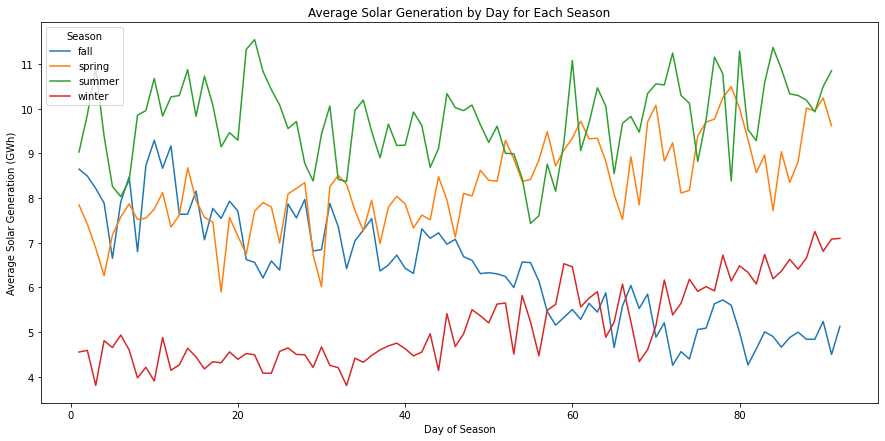

In [34]:
avg_solar = df.groupby(['season', 'month', 'day'])['solar_generation'].mean().reset_index()

# Create a sequence of days for each season
avg_solar['day_of_season'] = avg_solar.groupby('season').cumcount() + 1

# Plot
plt.figure(figsize=(15, 7))
sns.lineplot(data=avg_solar, x='day_of_season', y='solar_generation', hue='season')
plt.xlabel('Day of Season')
plt.ylabel('Average Solar Generation (GWh)')
plt.title('Average Solar Generation by Day for Each Season')
plt.legend(title='Season')
plt.show()

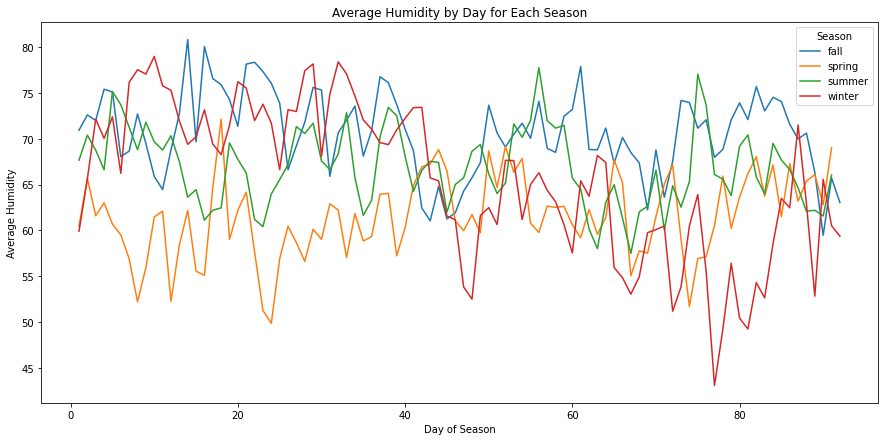

In [82]:
avg_solar = df.groupby(['season', 'month', 'day'])['humidity'].mean().reset_index()

# Create a sequence of days for each season
avg_solar['day_of_season'] = avg_solar.groupby('season').cumcount() + 1

# Plot
plt.figure(figsize=(15, 7))
sns.lineplot(data=avg_solar, x='day_of_season', y='humidity', hue='season')
plt.xlabel('Day of Season')
plt.ylabel('Average Humidity')
plt.title('Average Humidity by Day for Each Season')
plt.legend(title='Season')
plt.show()

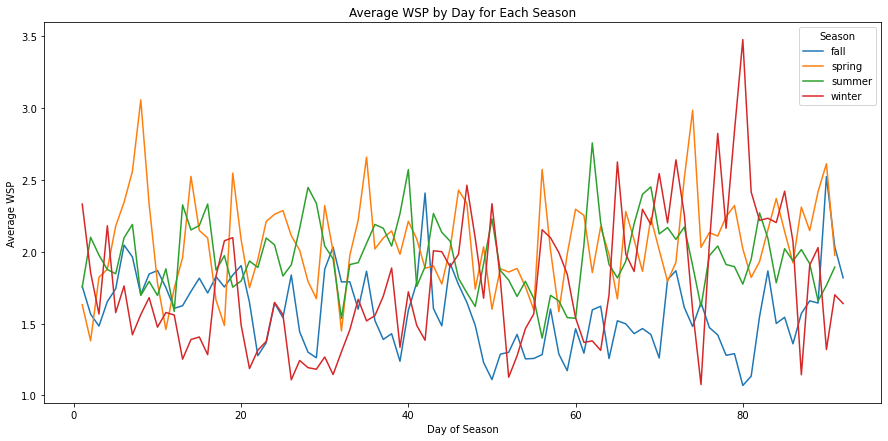

In [83]:
avg_solar = df.groupby(['season', 'month', 'day'])['wsp'].mean().reset_index()

# Create a sequence of days for each season
avg_solar['day_of_season'] = avg_solar.groupby('season').cumcount() + 1

# Plot
plt.figure(figsize=(15, 7))
sns.lineplot(data=avg_solar, x='day_of_season', y='wsp', hue='season')
plt.xlabel('Day of Season')
plt.ylabel('Average WSP')
plt.title('Average WSP by Day for Each Season')
plt.legend(title='Season')
plt.show()

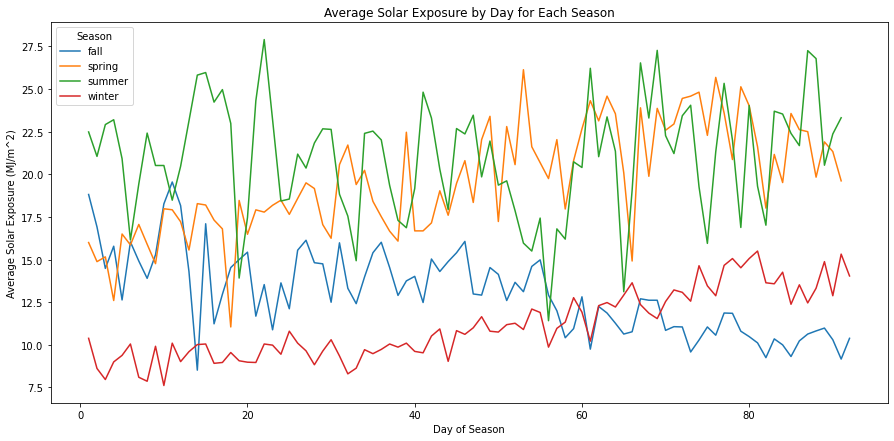

In [35]:
avg_exposure = df.groupby(['season', 'month', 'day'])['daily_solar_exposure'].mean().reset_index()

# Create a sequence of days for each season
avg_exposure['day_of_season'] = avg_exposure.groupby('season').cumcount() + 1

# Plot
plt.figure(figsize=(15, 7))
sns.lineplot(data=avg_exposure, x='day_of_season', y='daily_solar_exposure', hue='season')
plt.xlabel('Day of Season')
plt.ylabel('Average Solar Exposure (MJ/m^2)')
plt.title('Average Solar Exposure by Day for Each Season')
plt.legend(title='Season')
plt.show()

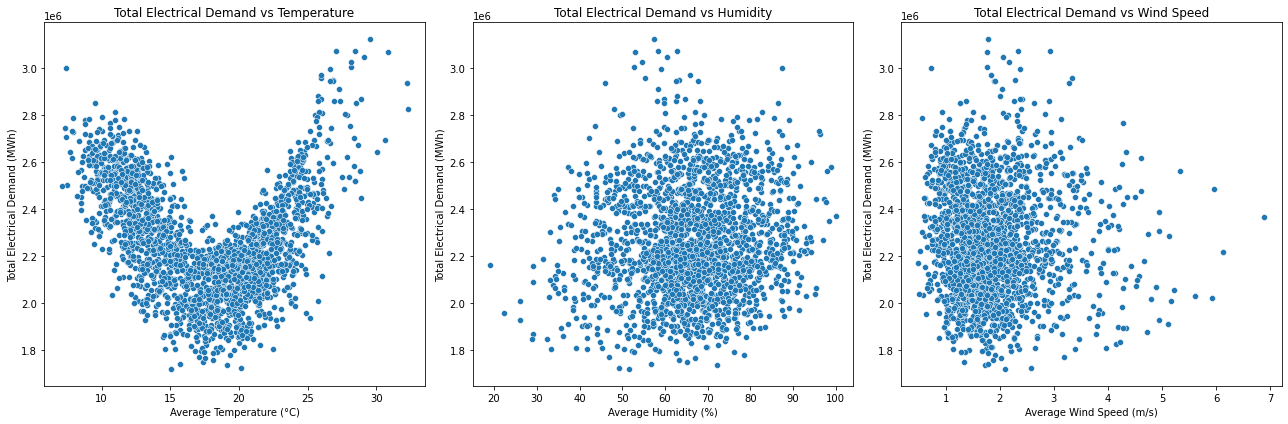

In [124]:
# Create a new figure with three subplots arranged in a 1x3 grid
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Scatterplot 1: Temperature vs. Total Demand
sns.scatterplot(data=df, x='temperature', y='total_demand', ax=axs[0])
axs[0].set_title('Total Electrical Demand vs Temperature')
axs[0].set_xlabel('Average Temperature (°C)')
axs[0].set_ylabel('Total Electrical Demand (MWh)')

# Scatterplot 2: Humidity vs. Total Demand 
sns.scatterplot(data=df, x='humidity', y='total_demand', ax=axs[1])
axs[1].set_title('Total Electrical Demand vs Humidity')
axs[1].set_xlabel('Average Humidity (%)')
axs[1].set_ylabel('Total Electrical Demand (MWh)')

# Scatterplot 3: Wind Speed vs. Total Demand 
sns.scatterplot(data=df, x='wsp', y='total_demand', ax=axs[2])
axs[2].set_title('Total Electrical Demand vs Wind Speed')
axs[2].set_xlabel('Average Wind Speed (m/s)')
axs[2].set_ylabel('Total Electrical Demand (MWh)')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

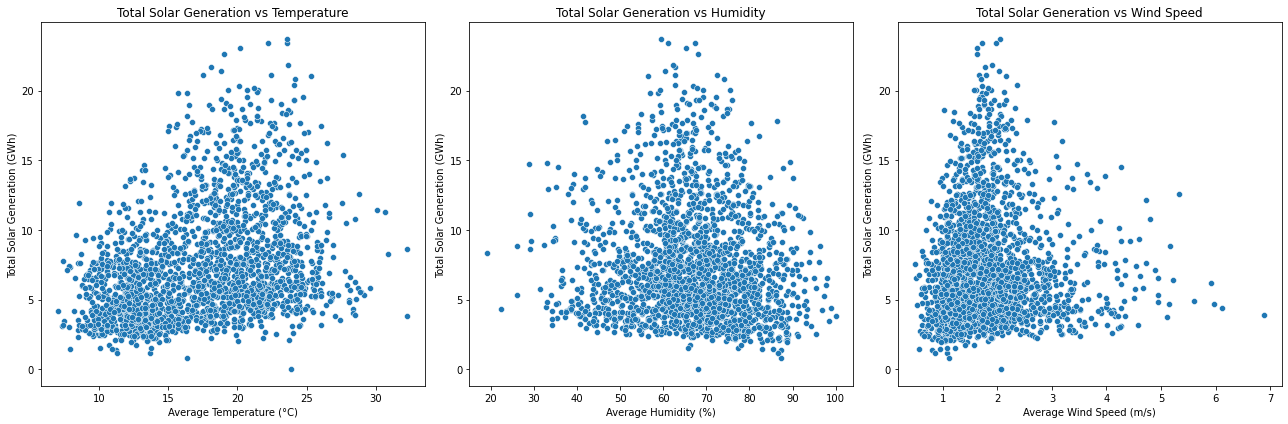

In [142]:
# Create a new figure with three subplots arranged in a 1x3 grid
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Scatterplot 1: Temperature vs. Solar Generation
sns.scatterplot(data=df, x='temperature', y='solar_generation', ax=axs[0])
axs[0].set_title('Total Solar Generation vs Temperature')
axs[0].set_xlabel('Average Temperature (°C)')
axs[0].set_ylabel('Total Solar Generation (GWh)')

# Scatterplot 2: Humidity vs. Solar Generation
sns.scatterplot(data=df, x='humidity', y='solar_generation', ax=axs[1])
axs[1].set_title('Total Solar Generation vs Humidity')
axs[1].set_xlabel('Average Humidity (%)')
axs[1].set_ylabel('Total Solar Generation (GWh)')

# Scatterplot 3: Wind Speed vs. Solar Generation
sns.scatterplot(data=df, x='wsp', y='solar_generation', ax=axs[2])
axs[2].set_title('Total Solar Generation vs Wind Speed')
axs[2].set_xlabel('Average Wind Speed (m/s)')
axs[2].set_ylabel('Total Solar Generation (GWh)')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

Text(0, 0.5, 'Total Electrical Demand (MWh)')

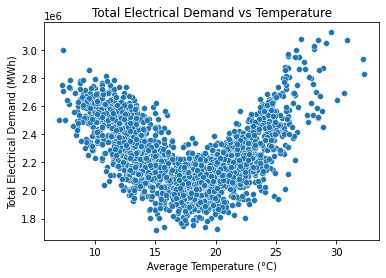

In [115]:
sns.scatterplot(data=df, x='temperature', y='total_demand')
plt.title('Total Electrical Demand vs Temperature')
plt.xlabel('Average Temperature (°C)')
plt.ylabel('Total Electrical Demand (MWh)')

Text(0, 0.5, 'Total Electrical Demand (MWh)')

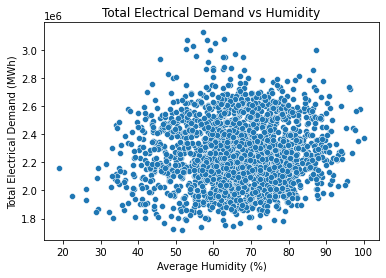

In [119]:
sns.scatterplot(data=df, x='humidity', y='total_demand')
plt.title('Total Electrical Demand vs Humidity')
plt.xlabel('Average Humidity (%)')
plt.ylabel('Total Electrical Demand (MWh)')

Text(0, 0.5, 'Total Electrical Demand (MWh)')

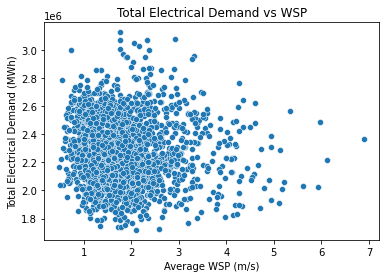

In [121]:
sns.scatterplot(data=df, x='wsp', y='total_demand')
plt.title('Total Electrical Demand vs WSP')
plt.xlabel('Average WSP (m/s)')
plt.ylabel('Total Electrical Demand (MWh)')

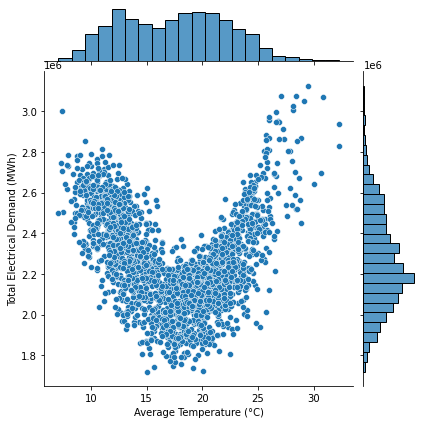

In [37]:
g = sns.jointplot(data=df, x='temperature', y='total_demand', kind='scatter')

g.ax_joint.set_xlabel('Average Temperature (°C)')
g.ax_joint.set_ylabel('Total Electrical Demand (MWh)')

plt.show()

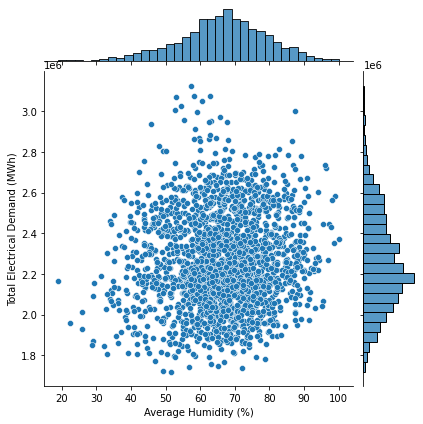

In [120]:
g = sns.jointplot(data=df, x='humidity', y='total_demand', kind='scatter')

g.ax_joint.set_xlabel('Average Humidity (%)')
g.ax_joint.set_ylabel('Total Electrical Demand (MWh)')

plt.show()

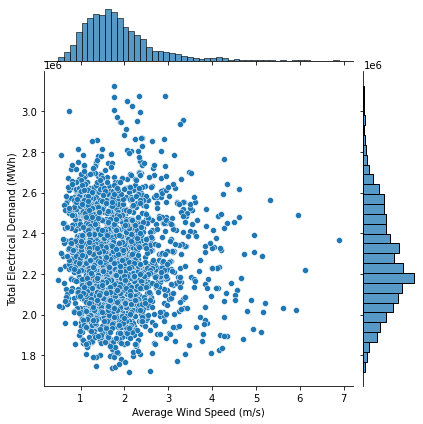

In [123]:
g = sns.jointplot(data=df, x='wsp', y='total_demand', kind='scatter')

g.ax_joint.set_xlabel('Average Wind Speed (m/s)')
g.ax_joint.set_ylabel('Total Electrical Demand (MWh)')

plt.show()

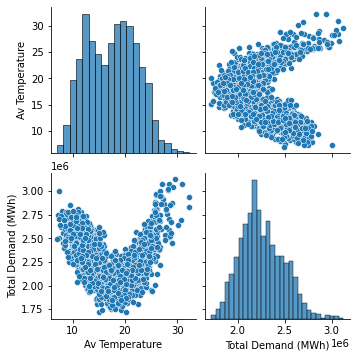

In [38]:
df_renamed = df[['temperature', 'total_demand']].rename(columns={
    'temperature': 'Av Temperature',
    'total_demand': 'Total Demand (MWh)'
})

sns.pairplot(data=df_renamed)
plt.show()

<AxesSubplot:xlabel='Total Electrical Demand (MWh)', ylabel='Average Temperature (°C)'>

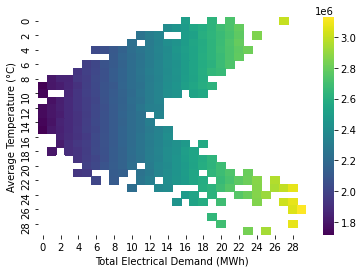

In [39]:
df_renamed = df[['temperature', 'total_demand']].rename(columns={
    'temperature': 'Average Temperature (°C)',
    'total_demand': 'Total Electrical Demand (MWh)'
})

bins = 30
temp_bins = pd.cut(df_renamed['Average Temperature (°C)'], bins=bins, labels=False, retbins=True)[0]
demand_bins = pd.cut(df_renamed['Total Electrical Demand (MWh)'], bins=bins, labels=False, retbins=True)[0]

heatmap_data = df_renamed.groupby([temp_bins, demand_bins])['Total Electrical Demand (MWh)'].mean().unstack()
sns.heatmap(heatmap_data, cmap='viridis')

In [40]:
correlation, p_value = spearmanr(df['solar_generation'], df['total_demand'])

print(f"Spearman's Rank Correlation: {correlation:.3f}")
print(f"P-value: {p_value:.5f}")

Spearman's Rank Correlation: -0.404
P-value: 0.00000


In [41]:
print("\n--- Descriptive Statistics for 'temperature' ---")
print(df['temperature'].describe())
print("\n--- Descriptive Statistics for 'total_demand' ---")
print(df['total_demand'].describe())
print("\n--- Descriptive Statistics for 'solar_generation' ---")
print(df['solar_generation'].describe())
print("\n--- Descriptive Statistics for 'daily_solar_exposure' ---")
print(df['daily_solar_exposure'].describe())


--- Descriptive Statistics for 'temperature' ---
count    2145.000000
mean       17.468632
std         4.729322
min         7.070833
25%        13.315789
50%        17.702083
75%        21.152000
max        32.272917
Name: temperature, dtype: float64

--- Descriptive Statistics for 'total_demand' ---
count    2.145000e+03
mean     2.259697e+06
std      2.297456e+05
min      1.719625e+06
25%      2.098693e+06
50%      2.228975e+06
75%      2.416262e+06
max      3.125305e+06
Name: total_demand, dtype: float64

--- Descriptive Statistics for 'solar_generation' ---
count    2145.000000
mean        7.399338
std         3.962179
min         0.000000
25%         4.488162
50%         6.308061
75%         9.249171
max        23.711070
Name: solar_generation, dtype: float64

--- Descriptive Statistics for 'daily_solar_exposure' ---
count    2145.000000
mean       16.216597
std         7.127175
min         0.800000
25%        10.900000
50%        14.800000
75%        21.400000
max        32.2000

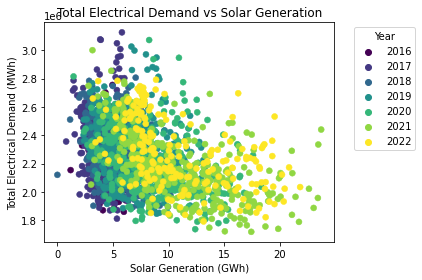

In [42]:
# Extract year and create a new column 'year'
df['year'] = pd.to_datetime(df['date']).dt.year

# Scatter plot
sns.scatterplot(data=df, x='solar_generation', y='total_demand', hue='year', palette='viridis', edgecolor=None)
plt.title('Total Electrical Demand vs Solar Generation')
plt.xlabel('Solar Generation (GWh)')
plt.ylabel('Total Electrical Demand (MWh)')
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')

# Display the plot
plt.tight_layout()
plt.show()

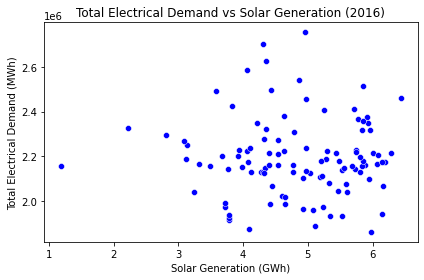

Pearson correlation between Solar Generation and Total Electrical Demand for 2016: -0.012
P-value: 0.903


In [43]:
df['year'] = pd.to_datetime(df['date']).dt.year

# Filter data for the year 2016
df_2016 = df[df['year'] == 2016]

# Scatter plot
sns.scatterplot(data=df_2016, x='solar_generation', y='total_demand', color='blue')
plt.title('Total Electrical Demand vs Solar Generation (2016)')
plt.xlabel('Solar Generation (GWh)')
plt.ylabel('Total Electrical Demand (MWh)')

# Display the plot
plt.tight_layout()
plt.show()

# Calculate the Pearson correlation and p-value
correlation, p_value = pearsonr(df_2016['solar_generation'], df_2016['total_demand'])

print(f"Pearson correlation between Solar Generation and Total Electrical Demand for 2016: {correlation:.3f}")
print(f"P-value: {p_value:.3f}")

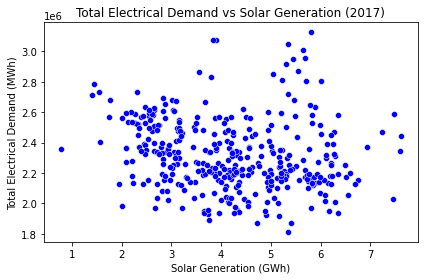

Pearson correlation between Solar Generation and Total Electrical Demand for 2017: -0.180
P-value: 0.001


In [44]:
# Filter data for the year 2017
df_2017 = df[df['year'] == 2017]

# Scatter plot
sns.scatterplot(data=df_2017, x='solar_generation', y='total_demand', color='blue')
plt.title('Total Electrical Demand vs Solar Generation (2017)')
plt.xlabel('Solar Generation (GWh)')
plt.ylabel('Total Electrical Demand (MWh)')

# Display the plot
plt.tight_layout()
plt.show()

# Calculate the Pearson correlation and p-value
correlation, p_value = pearsonr(df_2017['solar_generation'], df_2017['total_demand'])

print(f"Pearson correlation between Solar Generation and Total Electrical Demand for 2017: {correlation:.3f}")
print(f"P-value: {p_value:.3f}")

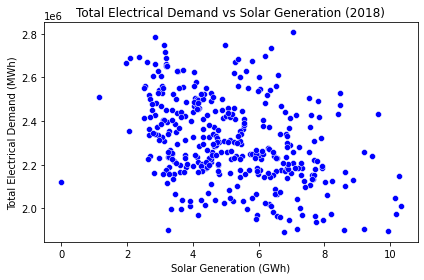

Pearson correlation between Solar Generation and Total Electrical Demand for 2018: -0.377
P-value: 0.000


In [45]:
# Filter data for the year 2018
df_2018 = df[df['year'] == 2018]

# Scatter plot
sns.scatterplot(data=df_2018, x='solar_generation', y='total_demand', color='blue')
plt.title('Total Electrical Demand vs Solar Generation (2018)')
plt.xlabel('Solar Generation (GWh)')
plt.ylabel('Total Electrical Demand (MWh)')

# Display the plot
plt.tight_layout()
plt.show()

# Calculate the Pearson correlation and p-value
correlation, p_value = pearsonr(df_2018['solar_generation'], df_2018['total_demand'])

print(f"Pearson correlation between Solar Generation and Total Electrical Demand for 2018: {correlation:.3f}")
print(f"P-value: {p_value:.3f}")

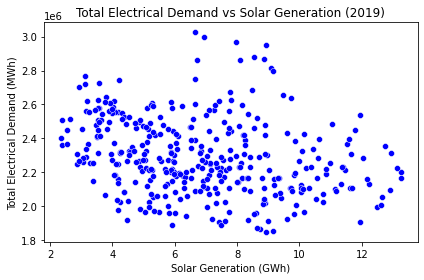

Pearson correlation between Solar Generation and Total Electrical Demand for 2019: -0.263
P-value: 0.000


In [46]:
# Filter data for the year 2019
df_2019 = df[df['year'] == 2019]

# Scatter plot
sns.scatterplot(data=df_2019, x='solar_generation', y='total_demand', color='blue')
plt.title('Total Electrical Demand vs Solar Generation (2019)')
plt.xlabel('Solar Generation (GWh)')
plt.ylabel('Total Electrical Demand (MWh)')

# Display the plot
plt.tight_layout()
plt.show()

# Calculate the Pearson correlation and p-value
correlation, p_value = pearsonr(df_2019['solar_generation'], df_2019['total_demand'])

print(f"Pearson correlation between Solar Generation and Total Electrical Demand for 2019: {correlation:.3f}")
print(f"P-value: {p_value:.3f}")

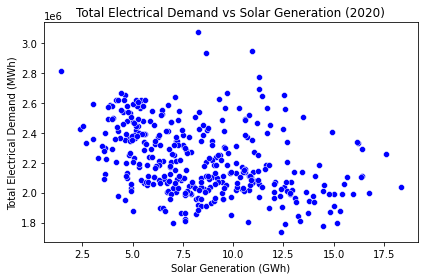

Pearson correlation between Solar Generation and Total Electrical Demand for 2020: -0.372
P-value: 0.000


In [47]:
# Filter data for the year 2020
df_2020 = df[df['year'] == 2020]

# Scatter plot
sns.scatterplot(data=df_2020, x='solar_generation', y='total_demand', color='blue')
plt.title('Total Electrical Demand vs Solar Generation (2020)')
plt.xlabel('Solar Generation (GWh)')
plt.ylabel('Total Electrical Demand (MWh)')

# Display the plot
plt.tight_layout()
plt.show()

# Calculate the Pearson correlation and p-value
correlation, p_value = pearsonr(df_2020['solar_generation'], df_2020['total_demand'])

print(f"Pearson correlation between Solar Generation and Total Electrical Demand for 2020: {correlation:.3f}")
print(f"P-value: {p_value:.3f}")

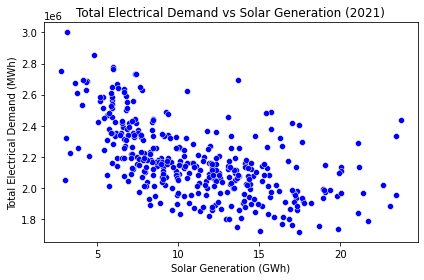

Pearson correlation between Solar Generation and Total Electrical Demand for 2021: -0.577
P-value: 0.000


In [48]:
# Filter data for the year 2021
df_2021 = df[df['year'] == 2021]

# Scatter plot
sns.scatterplot(data=df_2021, x='solar_generation', y='total_demand', color='blue')
plt.title('Total Electrical Demand vs Solar Generation (2021)')
plt.xlabel('Solar Generation (GWh)')
plt.ylabel('Total Electrical Demand (MWh)')

# Display the plot
plt.tight_layout()
plt.show()

# Calculate the Pearson correlation and p-value
correlation, p_value = pearsonr(df_2021['solar_generation'], df_2021['total_demand'])

print(f"Pearson correlation between Solar Generation and Total Electrical Demand for 2021: {correlation:.3f}")
print(f"P-value: {p_value:.3f}")

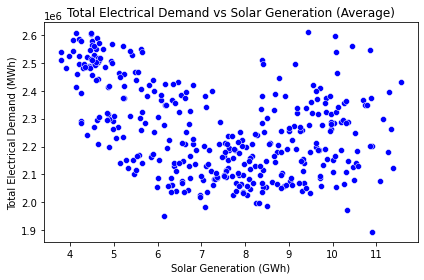

Pearson correlation between Solar Generation and Total Electrical Demand (Average): -0.416
P-value: 0.000


In [49]:
# Group by month and day and compute the average of total_demand and solar_generation
average_df = df.groupby(['month', 'day'])[['total_demand', 'solar_generation', 'daily_solar_exposure']].mean().reset_index()

# Scatter plot
sns.scatterplot(data=average_df, x='solar_generation', y='total_demand', color='blue')
plt.title('Total Electrical Demand vs Solar Generation (Average)')
plt.xlabel('Solar Generation (GWh)')
plt.ylabel('Total Electrical Demand (MWh)')

# Display the plot
plt.tight_layout()
plt.show()

# Calculate the Pearson correlation and p-value
correlation, p_value = pearsonr(average_df['solar_generation'], average_df['total_demand'])

print(f"Pearson correlation between Solar Generation and Total Electrical Demand (Average): {correlation:.3f}")
print(f"P-value: {p_value:.3f}")

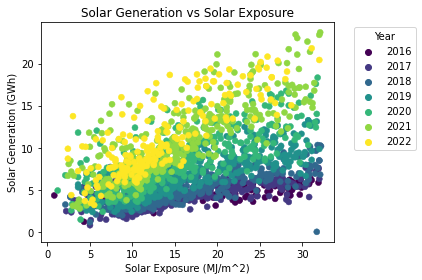

In [50]:
# Scatter plot
sns.scatterplot(data=df, x='daily_solar_exposure', y='solar_generation', hue='year', palette='viridis', edgecolor=None)
plt.title('Solar Generation vs Solar Exposure')
plt.xlabel('Solar Exposure (MJ/m^2)')
plt.ylabel('Solar Generation (GWh)')
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')

# Display the plot
plt.tight_layout()
plt.show()

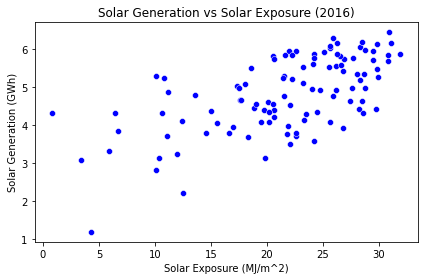

Pearson correlation between Solar Exposure and Solar Generation for 2016: 0.628
P-value: 0.000


In [51]:
# Scatter plot
sns.scatterplot(data=df_2016, x='daily_solar_exposure', y='solar_generation', color='blue')
plt.title('Solar Generation vs Solar Exposure (2016)')
plt.xlabel('Solar Exposure (MJ/m^2)')
plt.ylabel('Solar Generation (GWh)')

# Display the plot
plt.tight_layout()
plt.show()

# Calculate the Pearson correlation and p-value
correlation, p_value = pearsonr(df_2016['daily_solar_exposure'], df_2016['solar_generation'])

print(f"Pearson correlation between Solar Exposure and Solar Generation for 2016: {correlation:.3f}")
print(f"P-value: {p_value:.3f}")

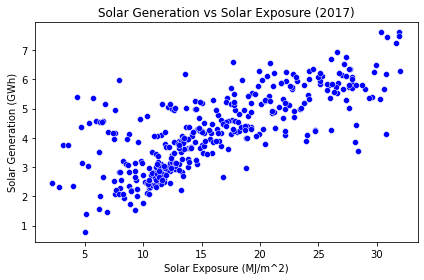

Pearson correlation between Solar Exposure and Solar Generation for 2017: 0.762
P-value: 0.000


In [52]:
# Scatter plot
sns.scatterplot(data=df_2017, x='daily_solar_exposure', y='solar_generation', color='blue')
plt.title('Solar Generation vs Solar Exposure (2017)')
plt.xlabel('Solar Exposure (MJ/m^2)')
plt.ylabel('Solar Generation (GWh)')

# Display the plot
plt.tight_layout()
plt.show()

# Calculate the Pearson correlation and p-value
correlation, p_value = pearsonr(df_2017['daily_solar_exposure'], df_2017['solar_generation'])

print(f"Pearson correlation between Solar Exposure and Solar Generation for 2017: {correlation:.3f}")
print(f"P-value: {p_value:.3f}")

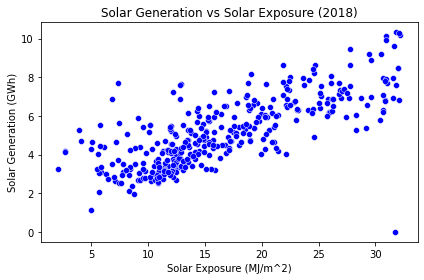

Pearson correlation between Solar Exposure and Solar Generation for 2018: 0.752
P-value: 0.000


In [53]:
# Scatter plot
sns.scatterplot(data=df_2018, x='daily_solar_exposure', y='solar_generation', color='blue')
plt.title('Solar Generation vs Solar Exposure (2018)')
plt.xlabel('Solar Exposure (MJ/m^2)')
plt.ylabel('Solar Generation (GWh)')

# Display the plot
plt.tight_layout()
plt.show()

# Calculate the Pearson correlation and p-value
correlation, p_value = pearsonr(df_2018['daily_solar_exposure'], df_2018['solar_generation'])

print(f"Pearson correlation between Solar Exposure and Solar Generation for 2018: {correlation:.3f}")
print(f"P-value: {p_value:.3f}")

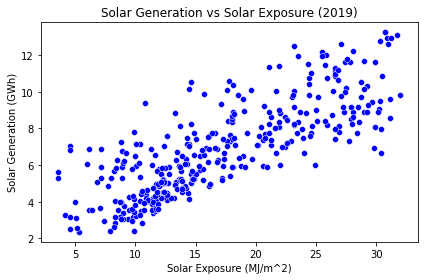

Pearson correlation between Solar Exposure and Solar Generation for 2019: 0.804
P-value: 0.000


In [54]:
# Scatter plot
sns.scatterplot(data=df_2019, x='daily_solar_exposure', y='solar_generation', color='blue')
plt.title('Solar Generation vs Solar Exposure (2019)')
plt.xlabel('Solar Exposure (MJ/m^2)')
plt.ylabel('Solar Generation (GWh)')

# Display the plot
plt.tight_layout()
plt.show()

# Calculate the Pearson correlation and p-value
correlation, p_value = pearsonr(df_2019['daily_solar_exposure'], df_2019['solar_generation'])

print(f"Pearson correlation between Solar Exposure and Solar Generation for 2019: {correlation:.3f}")
print(f"P-value: {p_value:.3f}")

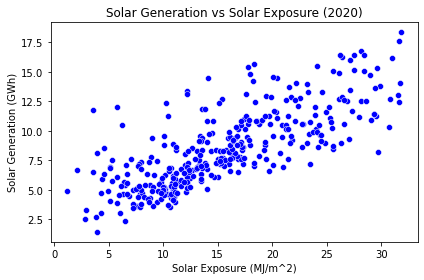

Pearson correlation between Solar Exposure and Solar Generation for 2020: 0.768
P-value: 0.000


In [55]:
# Scatter plot
sns.scatterplot(data=df_2020, x='daily_solar_exposure', y='solar_generation', color='blue')
plt.title('Solar Generation vs Solar Exposure (2020)')
plt.xlabel('Solar Exposure (MJ/m^2)')
plt.ylabel('Solar Generation (GWh)')

# Display the plot
plt.tight_layout()
plt.show()

# Calculate the Pearson correlation and p-value
correlation, p_value = pearsonr(df_2020['daily_solar_exposure'], df_2020['solar_generation'])

print(f"Pearson correlation between Solar Exposure and Solar Generation for 2020: {correlation:.3f}")
print(f"P-value: {p_value:.3f}")

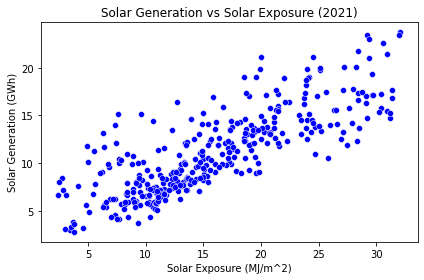

Pearson correlation between Solar Exposure and Solar Generation for 2021: 0.811
P-value: 0.000


In [56]:
# Scatter plot
sns.scatterplot(data=df_2021, x='daily_solar_exposure', y='solar_generation', color='blue')
plt.title('Solar Generation vs Solar Exposure (2021)')
plt.xlabel('Solar Exposure (MJ/m^2)')
plt.ylabel('Solar Generation (GWh)')

# Display the plot
plt.tight_layout()
plt.show()

# Calculate the Pearson correlation and p-value
correlation, p_value = pearsonr(df_2021['daily_solar_exposure'], df_2021['solar_generation'])

print(f"Pearson correlation between Solar Exposure and Solar Generation for 2021: {correlation:.3f}")
print(f"P-value: {p_value:.3f}")

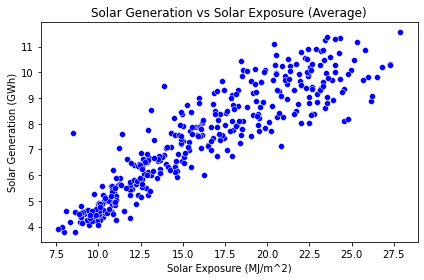

Pearson correlation between Solar Exposure and Solar Generation (Average): 0.912
P-value: 0.000


In [57]:
# Scatter plot
sns.scatterplot(data=average_df, x='daily_solar_exposure', y='solar_generation', color='blue')
plt.title('Solar Generation vs Solar Exposure (Average)')
plt.xlabel('Solar Exposure (MJ/m^2)')
plt.ylabel('Solar Generation (GWh)')

# Display the plot
plt.tight_layout()
plt.show()

# Calculate the Pearson correlation and p-value
correlation, p_value = pearsonr(average_df['daily_solar_exposure'], average_df['solar_generation'])

print(f"Pearson correlation between Solar Exposure and Solar Generation (Average): {correlation:.3f}")
print(f"P-value: {p_value:.3f}")

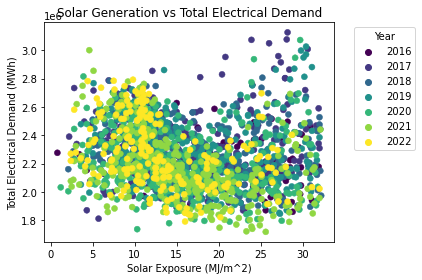

In [58]:
# Scatter plot
sns.scatterplot(data=df, x='daily_solar_exposure', y='total_demand', hue='year', palette='viridis', edgecolor=None)
plt.title('Solar Generation vs Total Electrical Demand')
plt.xlabel('Solar Exposure (MJ/m^2)')
plt.ylabel('Total Electrical Demand (MWh)')
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')

# Display the plot
plt.tight_layout()
plt.show()

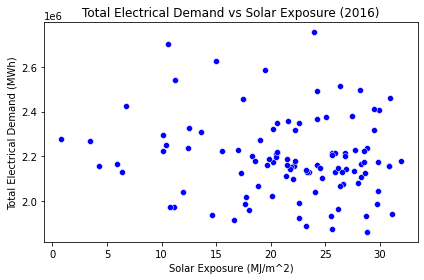

Pearson correlation between Solar Exposure and Solar Demand for 2016: -0.125
P-value: 0.201


In [59]:
# Scatter plot
sns.scatterplot(data=df_2016, x='daily_solar_exposure', y='total_demand', color='blue')
plt.title('Total Electrical Demand vs Solar Exposure (2016)')
plt.xlabel('Solar Exposure (MJ/m^2)')
plt.ylabel('Total Electrical Demand (MWh)')

# Display the plot
plt.tight_layout()
plt.show()

# Calculate the Pearson correlation and p-value
correlation, p_value = pearsonr(df_2016['daily_solar_exposure'], df_2016['total_demand'])

print(f"Pearson correlation between Solar Exposure and Solar Demand for 2016: {correlation:.3f}")
print(f"P-value: {p_value:.3f}")

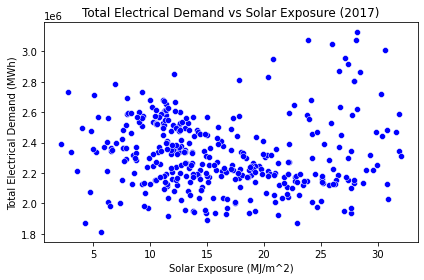

Pearson correlation between Solar Exposure and Solar Demand for 2017: -0.025
P-value: 0.630


In [60]:
# Scatter plot
sns.scatterplot(data=df_2017, x='daily_solar_exposure', y='total_demand', color='blue')
plt.title('Total Electrical Demand vs Solar Exposure (2017)')
plt.xlabel('Solar Exposure (MJ/m^2)')
plt.ylabel('Total Electrical Demand (MWh)')

# Display the plot
plt.tight_layout()
plt.show()

# Calculate the Pearson correlation and p-value
correlation, p_value = pearsonr(df_2017['daily_solar_exposure'], df_2017['total_demand'])

print(f"Pearson correlation between Solar Exposure and Solar Demand for 2017: {correlation:.3f}")
print(f"P-value: {p_value:.3f}")

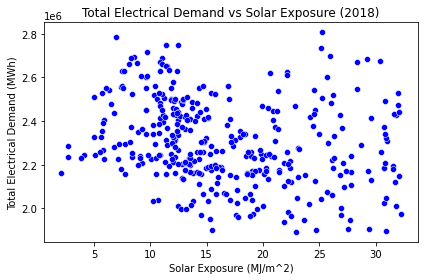

Pearson correlation between Solar Exposure and Solar Demand for 2018: -0.249
P-value: 0.000


In [61]:
# Scatter plot
sns.scatterplot(data=df_2018, x='daily_solar_exposure', y='total_demand', color='blue')
plt.title('Total Electrical Demand vs Solar Exposure (2018)')
plt.xlabel('Solar Exposure (MJ/m^2)')
plt.ylabel('Total Electrical Demand (MWh)')

# Display the plot
plt.tight_layout()
plt.show()

# Calculate the Pearson correlation and p-value
correlation, p_value = pearsonr(df_2018['daily_solar_exposure'], df_2018['total_demand'])

print(f"Pearson correlation between Solar Exposure and Solar Demand for 2018: {correlation:.3f}")
print(f"P-value: {p_value:.3f}")

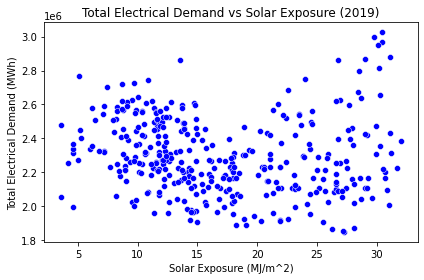

Pearson correlation between Solar Exposure and Solar Demand for 2019: -0.095
P-value: 0.069


In [62]:
# Scatter plot
sns.scatterplot(data=df_2019, x='daily_solar_exposure', y='total_demand', color='blue')
plt.title('Total Electrical Demand vs Solar Exposure (2019)')
plt.xlabel('Solar Exposure (MJ/m^2)')
plt.ylabel('Total Electrical Demand (MWh)')

# Display the plot
plt.tight_layout()
plt.show()

# Calculate the Pearson correlation and p-value
correlation, p_value = pearsonr(df_2019['daily_solar_exposure'], df_2019['total_demand'])

print(f"Pearson correlation between Solar Exposure and Solar Demand for 2019: {correlation:.3f}")
print(f"P-value: {p_value:.3f}")

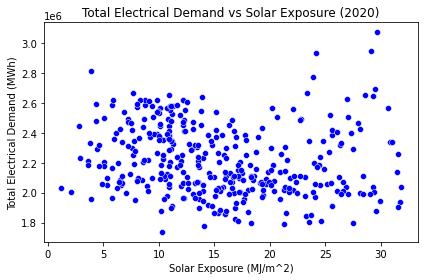

Pearson correlation between Solar Exposure and Solar Demand for 2020: -0.157
P-value: 0.003


In [63]:
# Scatter plot
sns.scatterplot(data=df_2020, x='daily_solar_exposure', y='total_demand', color='blue')
plt.title('Total Electrical Demand vs Solar Exposure (2020)')
plt.xlabel('Solar Exposure (MJ/m^2)')
plt.ylabel('Total Electrical Demand (MWh)')

# Display the plot
plt.tight_layout()
plt.show()

# Calculate the Pearson correlation and p-value
correlation, p_value = pearsonr(df_2020['daily_solar_exposure'], df_2020['total_demand'])

print(f"Pearson correlation between Solar Exposure and Solar Demand for 2020: {correlation:.3f}")
print(f"P-value: {p_value:.3f}")

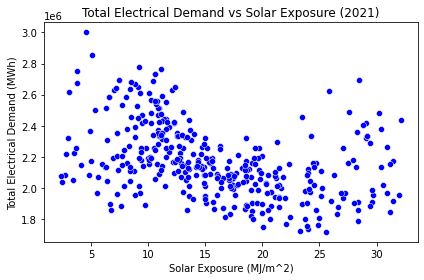

Pearson correlation between Solar Exposure and Solar Demand for 2021: -0.423
P-value: 0.000


In [64]:
# Scatter plot
sns.scatterplot(data=df_2021, x='daily_solar_exposure', y='total_demand', color='blue')
plt.title('Total Electrical Demand vs Solar Exposure (2021)')
plt.xlabel('Solar Exposure (MJ/m^2)')
plt.ylabel('Total Electrical Demand (MWh)')

# Display the plot
plt.tight_layout()
plt.show()

# Calculate the Pearson correlation and p-value
correlation, p_value = pearsonr(df_2021['daily_solar_exposure'], df_2021['total_demand'])

print(f"Pearson correlation between Solar Exposure and Solar Demand for 2021: {correlation:.3f}")
print(f"P-value: {p_value:.3f}")

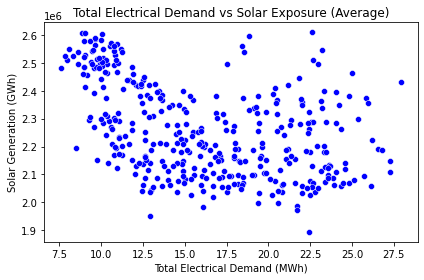

Pearson correlation between Solar Exposure and Total Demand (Average): -0.441
P-value: 0.000


In [65]:
# Scatter plot
sns.scatterplot(data=average_df, x='daily_solar_exposure', y='total_demand', color='blue')
plt.title('Total Electrical Demand vs Solar Exposure (Average)')
plt.xlabel('Total Electrical Demand (MWh)')
plt.ylabel('Solar Generation (GWh)')

# Display the plot
plt.tight_layout()
plt.show()

# Calculate the Pearson correlation and p-value
correlation, p_value = pearsonr(average_df['daily_solar_exposure'], average_df['total_demand'])

print(f"Pearson correlation between Solar Exposure and Total Demand (Average): {correlation:.3f}")
print(f"P-value: {p_value:.3f}")

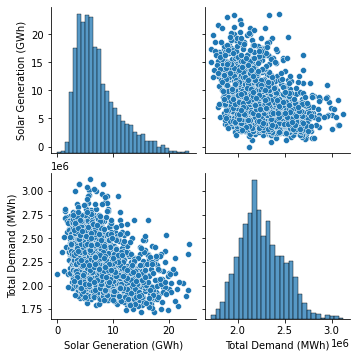

In [66]:
df_renamed = df[['solar_generation', 'total_demand']].rename(columns={
    'solar_generation': 'Solar Generation (GWh)',
    'total_demand': 'Total Demand (MWh)'
})

sns.pairplot(data=df_renamed)
plt.show()

<AxesSubplot:xlabel='Total Electrical Demand (MWh)', ylabel='Solar Generation (GWh)'>

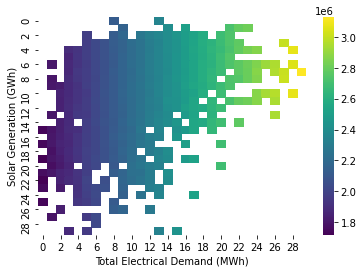

In [67]:
df_renamed = df[['solar_generation', 'total_demand']].rename(columns={
    'solar_generation': 'Solar Generation (GWh)',
    'total_demand': 'Total Electrical Demand (MWh)'
})

bins = 30
temp_bins = pd.cut(df_renamed['Solar Generation (GWh)'], bins=bins, labels=False, retbins=True)[0]
demand_bins = pd.cut(df_renamed['Total Electrical Demand (MWh)'], bins=bins, labels=False, retbins=True)[0]

heatmap_data = df_renamed.groupby([temp_bins, demand_bins])['Total Electrical Demand (MWh)'].mean().unstack()
sns.heatmap(heatmap_data, cmap='viridis')

In [68]:
correlation_coeff = df['solar_generation'].corr(df['total_demand'])
print(f"Pearson Correlation Coefficient: {correlation_coeff:.3f}")

Pearson Correlation Coefficient: -0.393


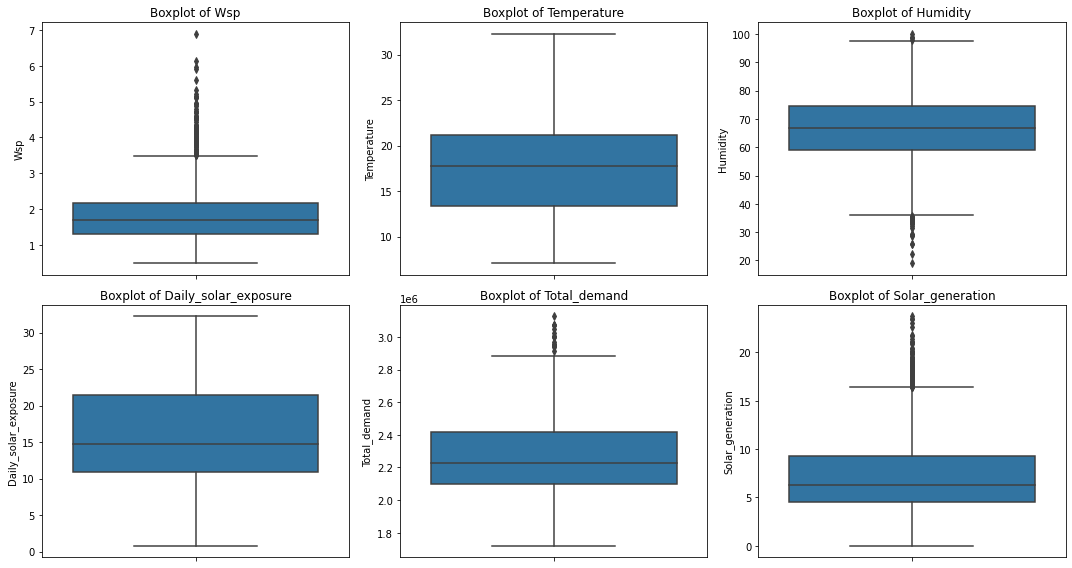

In [91]:
# List of dataframe attributes for boxplots
attributes_for_boxplots = ['wsp', 'temperature', 'humidity', 'daily_solar_exposure', 'total_demand','solar_generation']  

# Calculate the number of rows and columns for the subplots
num_attributes = len(attributes_for_boxplots)
num_columns = 3
num_rows = (num_attributes + num_columns - 1) // num_columns

# Create a new figure with subplots arranged in a 3xN grid
fig, axs = plt.subplots(num_rows, num_columns, figsize=(15, 4 * num_rows))
fig.subplots_adjust(hspace=0.5)

# Iterate through the attributes and create boxplots
for i, attribute in enumerate(attributes_for_boxplots):
    row = i // num_columns
    col = i % num_columns
    sns.boxplot(y=merged_df[attribute], ax=axs[row, col])
    axs[row, col].set_ylabel(attribute.capitalize())
    axs[row, col].set_title(f'Boxplot of {attribute.capitalize()}')

# Remove any empty subplots if there are fewer attributes than available subplots
for i in range(num_attributes, num_rows * num_columns):
    fig.delaxes(axs.flatten()[i])

# Show the plots
plt.tight_layout()
plt.show()

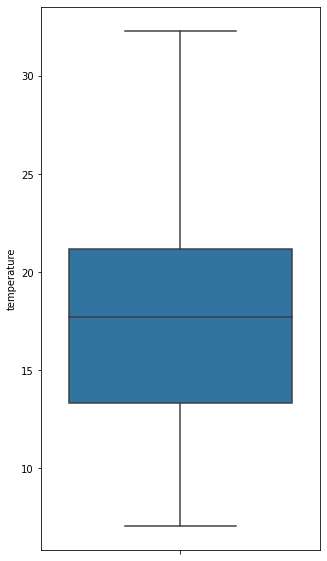

In [69]:
plt.figure(figsize=(5, 10))
sns.boxplot(y=merged_df['temperature']);
plt.show()

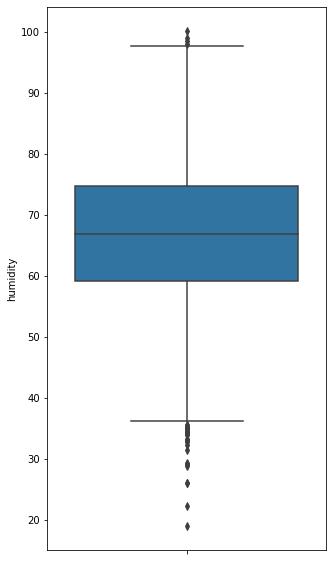

In [87]:
plt.figure(figsize=(5, 10))
sns.boxplot(y=merged_df['humidity']);
plt.show()

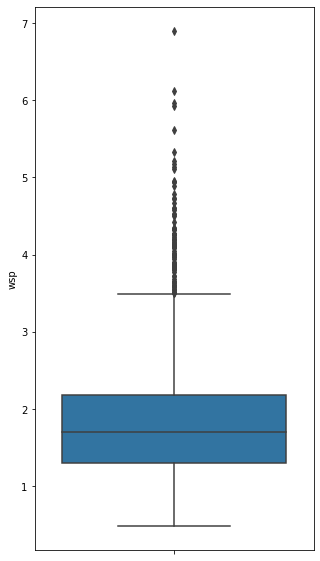

In [88]:
plt.figure(figsize=(5, 10))
sns.boxplot(y=merged_df['wsp']);
plt.show()

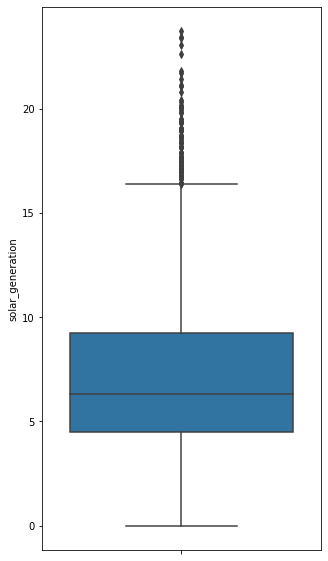

In [70]:
plt.figure(figsize=(5, 10))
sns.boxplot(y=merged_df['solar_generation']);
plt.show()

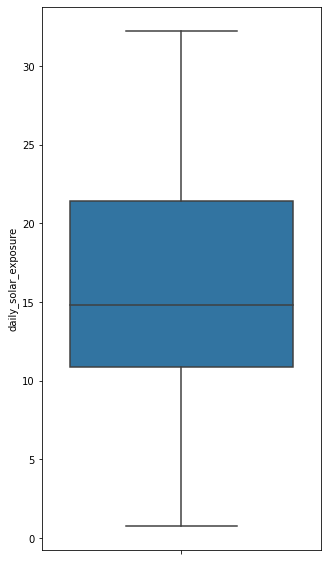

In [71]:
plt.figure(figsize=(5, 10))
sns.boxplot(y=merged_df['daily_solar_exposure']);
plt.show()

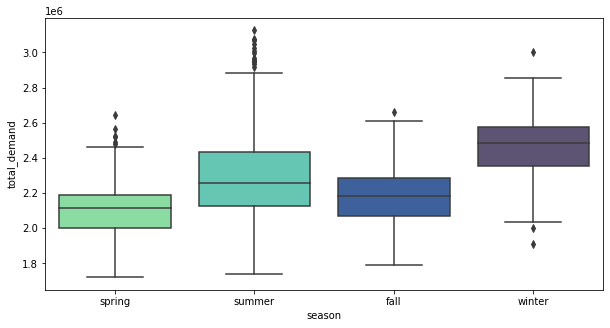

In [72]:
custom_palette = ["#7CEA9C", "#55D6BE", "#2E5EAA", "#5B4E77"]
sns.set_palette(custom_palette)
plt.figure(figsize=(10, 5))
sns.boxplot(x=merged_df['season'], y=merged_df['total_demand']);
plt.show()

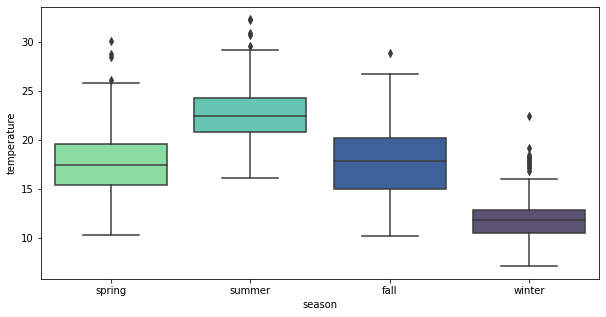

In [73]:
custom_palette = ["#7CEA9C", "#55D6BE", "#2E5EAA", "#5B4E77"]
sns.set_palette(custom_palette)
plt.figure(figsize=(10, 5))
sns.boxplot(x=merged_df['season'], y=merged_df['temperature']);
plt.show()

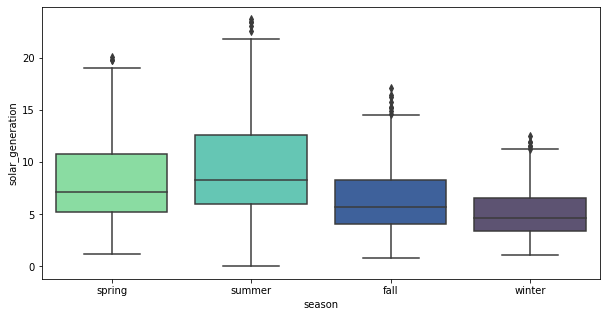

In [74]:
custom_palette = ["#7CEA9C", "#55D6BE", "#2E5EAA", "#5B4E77"]
sns.set_palette(custom_palette)
plt.figure(figsize=(10, 5))
sns.boxplot(x=merged_df['season'], y=merged_df['solar_generation']);
plt.show()